In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta, datetime, date
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks

import scipy.stats as stats
from scipy.signal import welch

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import zlib
from tslearn.piecewise import PiecewiseAggregateApproximation
import pickle
from sklearn.cluster import DBSCAN
from tqdm import tqdm
from prettytable import PrettyTable
from sklearn.preprocessing import MinMaxScaler
import itertools as it

from tensorflow.keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from sklearn import metrics
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax, TimeSeriesResampler 

import sys
sys.path.insert(1, '../')
from utilities import get_path
sys.path.insert(1, '../DM_11_TASK2')
from clusteringUtilities import get_metrics


In [7]:
DATA_PATH = get_path()

# Extract timeseries

In [4]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_clean.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')

In [5]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9816550 entries, 0 to 9816549
Data columns (total 10 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   user_id                   object
 1   publication_date          object
 2   text                      object
 3   publication_date_in_secs  int64 
 4   retweet_count             int64 
 5   reply_count               int64 
 6   favorite_count            int64 
 7   num_hashtags              int64 
 8   num_urls                  int64 
 9   num_mentions              int64 
dtypes: int64(7), object(3)
memory usage: 748.9+ MB


In [6]:
# Get all the tweets published in the 2019
start_2019 = pd.to_datetime(["20190101"]).astype(np.int64)[0]
end_2019 = pd.to_datetime(["20191231"]).astype(np.int64)[0]
df_tweets2019 = df_tweets[(df_tweets['publication_date_in_secs'] >= start_2019) & (df_tweets['publication_date_in_secs'] <= end_2019)]

In [7]:
df_users.id = df_users.id.astype(str)
df_merged = df_tweets2019.merge(df_users, left_on='user_id', right_on='id', how='right')

In [8]:
df_merged['publication_date_in_secs'].shape

(4340154,)

In [9]:
df_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4340154 entries, 0 to 4340153
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   user_id                    4335433 non-null  object 
 1   publication_date           4335433 non-null  object 
 2   text                       4329687 non-null  object 
 3   publication_date_in_secs   4335433 non-null  float64
 4   retweet_count              4335433 non-null  float64
 5   reply_count                4335433 non-null  float64
 6   favorite_count             4335433 non-null  float64
 7   num_hashtags               4335433 non-null  float64
 8   num_urls                   4335433 non-null  float64
 9   num_mentions               4335433 non-null  float64
 10  id                         4340154 non-null  object 
 11  name                       4340153 non-null  object 
 12  lang                       4340154 non-null  object 
 13  bot         

In [10]:
#Drop the row with null value in the user_id column
df_merged.user_id.fillna(-1, inplace=True)
users_list = df_merged.user_id.unique()
users_list = users_list.tolist()
users_list.remove(-1)

In [11]:
len(users_list)

6787

In [15]:
def extract_daily_scores(df):

    day = date(2019,1,1)
    end = date(2019,12,31)

    success_scores = []

    df = df.groupby(by=['publication_date'])
    
    while day <= end:
        try:
            group = df.get_group(day)
            # Compute success score for that day for that user
            acceptance_score = group['retweet_count'].sum() + group['reply_count'].sum() + group['favorite_count'].sum()
            diffusion_score = group['num_hashtags'].sum() + group['num_mentions'].sum() + group['num_urls'].sum()
            success_scores.append(acceptance_score / (diffusion_score + 0.1))
        except KeyError:
            success_scores.append(-1)

        day = day + timedelta(days=1)

    return success_scores
        

In [16]:
def extract_users_scores(df):

    df_grouped_pub_day = df.groupby(by=['user_id'])
    users_scores = {}
    
    # Extract for each user a timeseries of daily scores about tweets of 2019
    for user in users_list:
        user_group = df_grouped_pub_day.get_group(str(user))
        users_scores[user] = extract_daily_scores(user_group)
    
    return users_scores


In [17]:
res = extract_users_scores(df_merged)

In [18]:
df_timeseries = pd.DataFrame(res.items())

In [19]:
df_timeseries.head()

0                                                  1
0  2353593986  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
1  2358850842  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
2   466124818  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
3  2199062688  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
4  2357425536  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...

In [22]:
df_timeseries.rename(columns={0: 'user_id', 1: 'success_scores'}, inplace=True)

In [23]:
df_timeseries.head()

user_id                                     success_scores  \
0  2353593986  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
1  2358850842  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
2   466124818  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
3  2199062688  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
4  2357425536  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   

                                        publications  
0  [1.562816946e+18, 1.561104313e+18, 1.55446806e...  
1  [1.563961546e+18, 1.556421671e+18, 1.556749642...  
2  [1.571747079e+18, 1.562044389e+18, 1.567421266...  
3  [1.564036843e+18, 1.561534888e+18, 1.561055373...  
4  [1.563345763e+18, 1.554433812e+18, 1.562575589...

# Checkpoint

In [24]:
df_timeseries.to_csv(path_or_buf=DATA_PATH+'tweets_timeseries.csv', sep='#', index=False)

In [8]:
df_timeseries = pd.read_csv(DATA_PATH+'tweets_timeseries.csv', sep='#')

# Timeseries handling

In [9]:
ts_list = df_timeseries.success_scores.values

In [10]:
# Cast timeseries from list to numpy array
timeseries_list = []
for i, item in enumerate(ts_list):
    timeseries_list.append(eval(item))
    timeseries_list[i] = np.array(timeseries_list[i], dtype=object)

# Reshape timeseries as numpy array and numpy matrix
timeseries_list = np.array(timeseries_list, dtype=object)
timeseries_list.shape

(6787, 365)

In [11]:
def plot_ts(ts_list, save=True, log_y=False):
    #Plot a direct comparison between all the extracted timeseries
    plt.figure(figsize=(30,5))
    plt.plot(ts_list.reshape(ts_list.shape[1], ts_list.shape[0]))
    if log_y:
        plt.yscale('log')
    if save:
        plt.savefig('./timeseries/ts_denoised')
    plt.show()

From the first plot is noticeable that there are few peaks with a magnitude of 1e6. It means that these users have a big acceptance score and a small diffusion score. More in general, from the second plot is possible to see that the majority of values are bounded between 1e-1 and 1e4.

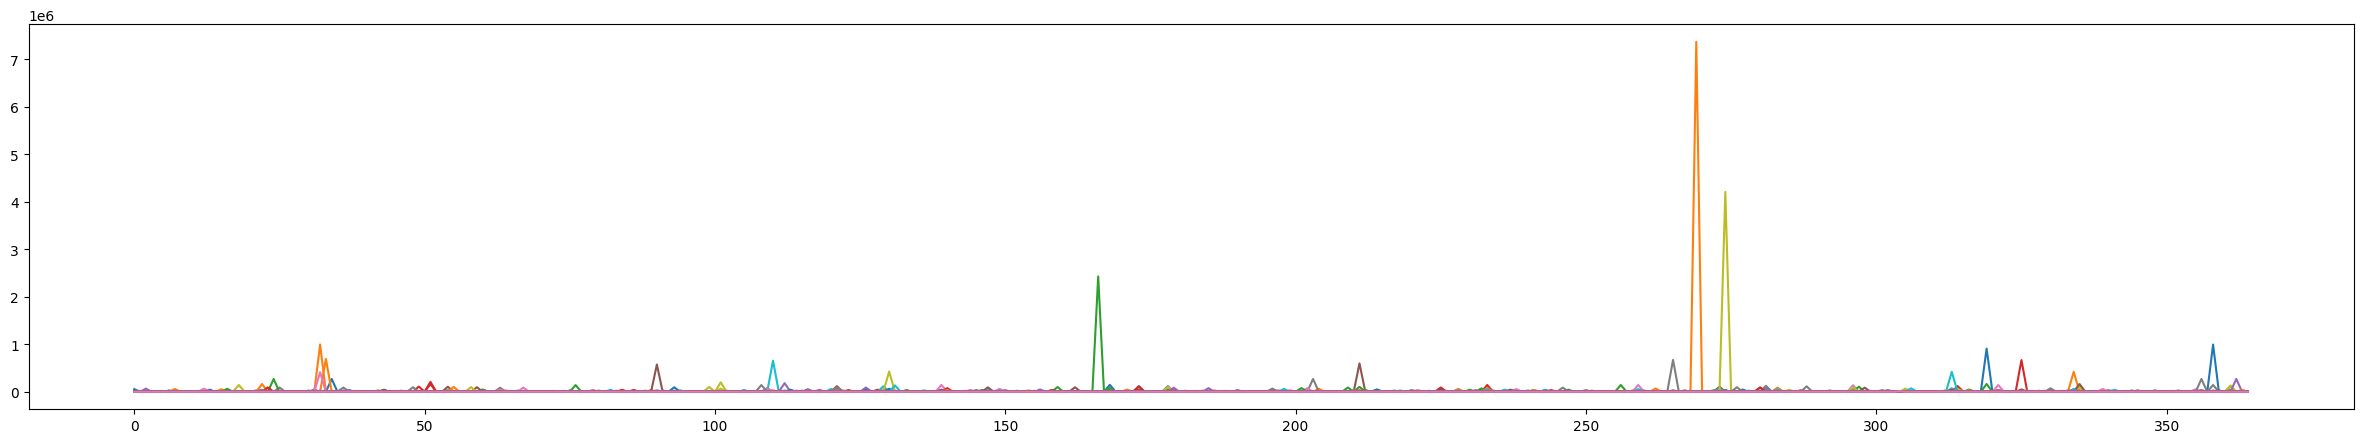

In [17]:
#Plots timeseries
plot_ts(timeseries_list, save=False, log_y=False)

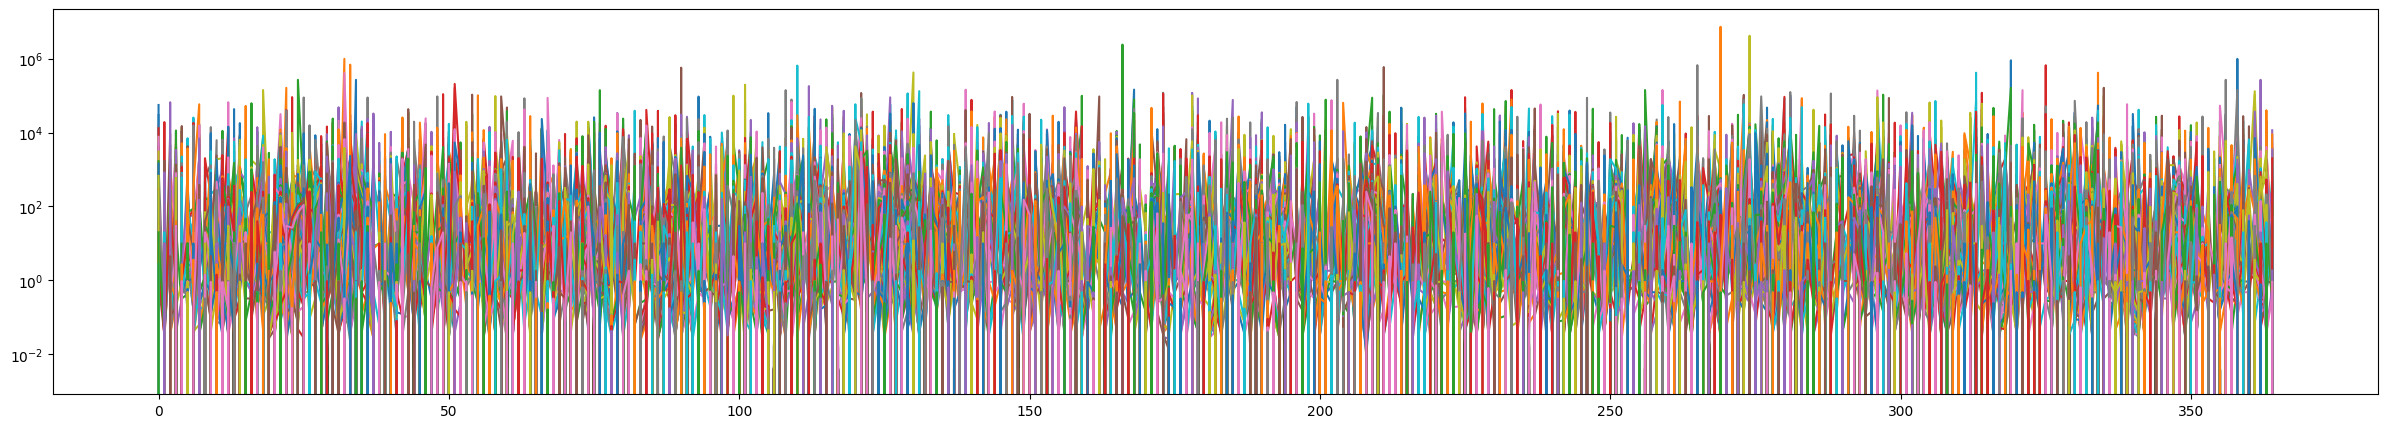

In [18]:
#Plots timeseries in log scale
plot_ts(timeseries_list, save=False, log_y=True)

In [37]:
timeseries_list.shape

(6787, 365)

# Utilities

In [12]:
def plot_crosstab(labels, column, legend_labels, xlabel='Cluster', ylabel='bot', path=None):
    bot_ct = pd.crosstab(labels, column)
    fig, ax = plt.subplots(figsize=(24, 8))
    bot_ct.plot(kind='bar', stacked=False, ax=ax)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(prop={'size': 30}, labels=legend_labels)
    if path is not None:
        plt.savefig(path+'/crosstab_bot.png')

In [13]:
def plot_lang_histogram(labels, languages, out_path=False, path=''):

    # Plot w.r.t. languages
    lang_ct = pd.crosstab(labels, languages)
    to_agg = lang_ct.columns[lang_ct.sum() < 30]
    lang_ct['others'] = lang_ct[to_agg].sum(axis=1)
    lang_ct.drop(columns = to_agg, inplace=True)
    fig, ax = plt.subplots(figsize=(24, 8))
    lang_ct.plot(kind='bar', stacked=False, ax=ax)
    plt.xlabel('Cluster')
    plt.ylabel('lang')
    plt.yscale('log')
    plt.legend(prop={'size': 15}, loc="upper right")
    if out_path:
        plt.savefig(path)

In [14]:
def to_log(data):
    data = np.log(data.astype('float64'))
    
    mask = np.isneginf(data)
    data = np.where(mask, 0, data)

    mask = np.isnan(data)
    data = np.where(mask, -1, data)

    return data

# Scale data passed with the indicated scaler
def scale_ts(data, scaler):
    scaled = []
    for data in data:
        scaled.append(scaler.fit_transform(data.reshape(1, -1)).flatten())

    return np.array(scaled)

In [15]:
# Create folder
import os

try: 
    os.mkdir('timeseries')
except FileExistsError:
    pass

In [16]:
try:
    df_ts_users = df_timeseries.merge(df_users, left_on='user_id', right_on='id')
except:
    df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')
    df_ts_users = df_timeseries.merge(df_users, left_on='user_id', right_on='id')

# Shape-based clustering

In [16]:
# Performs kmeans and plots centroids
def run_ts_kmeans(data, n_clust, metric, max_iter=100, random_state=42, out_path=True, dir='.', scaler_name='', log=True):
    
    try:
        os.mkdir(f'timeseries/{dir}')
    except FileExistsError:
        pass
    
    data_reshaped = np.reshape(data, (data.shape[0], data.shape[1], 1))
    km = TimeSeriesKMeans(n_clusters=n_clust, metric=metric, max_iter=max_iter, random_state=random_state, n_init=10)
    km.fit(data_reshaped)
    if out_path:
        #Get unique labels
        unique_labels = np.unique(km.labels_)
        plt.figure(figsize=(30,5))
        plt.title(f'k={n_clust} metric={metric}')
        plt.plot(km.cluster_centers_.reshape(data.shape[1], n_clust))
        plt.legend(labels=unique_labels, loc="upper right")
        if log:
            plt.yscale('log')
        plt.savefig(f'timeseries/{dir}/shape_clust_{n_clust}_{metric}_{scaler_name}')

    #Print the number of element in each cluster
    print(f'k={n_clust}')
    string = ""
    for i in range(0,n_clust):
        string += f' {i+1}={km.labels_.tolist().count(i)} '

    print(string)
    
    return km

In [217]:
# Grid search to find the best parameters for TimeseriesKmeans (including data transformation)
min_centr = 2
max_centr = 25
params = {
    "scaler": [TimeSeriesScalerMeanVariance(mu=0., std=1.),
    TimeSeriesScalerMinMax(value_range=(1., 2.))],
    "metrics": ["euclidean"],
    "n_centr": [i for i in range(min_centr,max_centr+1)],
}

# Perform a cartesian product of the params dict with itself
keys, values = zip(*params.items())
combo_list = list(it.product(*(values)))

res = []

data = timeseries_list.copy()
# Log data in order to improve performances
logged = to_log(data)

for i in tqdm(range(len(combo_list))):

    res_dict = {
        "scaler": combo_list[i][0],
        "metrics" : combo_list[i][1],
        "n_centr" : combo_list[i][2],
    }
    # Scale logged data
    scaled = scale_ts(logged, res_dict['scaler'])
    # Perform kmeans
    kmeans = run_ts_kmeans(scaled, n_clust=res_dict["n_centr"], metric=res_dict["metrics"], out_path=False, dir='shape_based_clust', scaler_name=res_dict['scaler'])
    # Save centroids, labels and scores in a dict
    res_dict['labels'] = kmeans.labels_
    res_dict['inertia'] = kmeans.inertia_
    res_dict['centroids'] = kmeans.cluster_centers_

    res_dict['silohuette'], res_dict['DBscore'] = get_metrics(scaled, kmeans.labels_, print_out=False)

    res.append(res_dict)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_27352\3580474094.py:2: RuntimeWarning: divide by zero encountered in log
  data = np.log(data.astype('float64'))
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_27352\3580474094.py:2: RuntimeWarning: invalid value encountered in log
  data = np.log(data.astype('float64'))
  0%|          | 0/48 [00:00<?, ?it/s]

k=2
 1=4405  2=2382 


  2%|▏         | 1/48 [00:47<36:59, 47.22s/it]

k=3
 1=901  2=3504  3=2382 


  4%|▍         | 2/48 [01:19<29:18, 38.23s/it]

k=4
 1=972  2=898  3=2389  4=2528 


  6%|▋         | 3/48 [01:49<25:59, 34.67s/it]

k=5
 1=1561  2=832  3=900  4=972  5=2522 


  8%|▊         | 4/48 [02:32<27:41, 37.77s/it]

k=6
 1=566  2=831  3=1561  4=1955  5=973  6=901 


 10%|█         | 5/48 [03:23<30:40, 42.79s/it]

k=7
 1=556  2=569  3=831  4=974  5=1959  6=1559  7=339 


 12%|█▎        | 6/48 [04:23<34:03, 48.65s/it]

k=8
 1=971  2=569  3=1189  4=1136  5=804  6=418  7=338  8=1362 


 15%|█▍        | 7/48 [05:42<40:01, 58.58s/it]

k=9
 1=1181  2=409  3=1190  4=445  5=568  6=971  7=887  8=804  9=332 


 17%|█▋        | 8/48 [06:38<38:22, 57.57s/it]

k=10
 1=914  2=1190  3=971  4=565  5=441  6=804  7=818  8=404  9=359  10=321 


 19%|█▉        | 9/48 [07:58<42:04, 64.73s/it]

k=11
 1=394  2=971  3=565  4=564  5=319  6=668  7=774  8=902  9=366  10=443  11=821 


 21%|██        | 10/48 [09:10<42:22, 66.90s/it]

k=12
 1=235  2=301  3=640  4=568  5=354  6=884  7=1056  8=1033  9=405  10=334  11=737  12=240 


 23%|██▎       | 11/48 [10:17<41:19, 67.01s/it]

k=13
 1=366  2=597  3=369  4=565  5=971  6=871  7=709  8=217  9=319  10=398  11=526  12=632  13=247 


 25%|██▌       | 12/48 [11:55<45:46, 76.29s/it]

k=14
 1=630  2=395  3=740  4=334  5=636  6=355  7=163  8=266  9=341  10=759  11=1064  12=244  13=294  14=566 


 27%|██▋       | 13/48 [13:38<49:16, 84.47s/it]

k=15
 1=630  2=395  3=32  4=767  5=636  6=353  7=161  8=268  9=341  10=713  11=1064  12=244  13=294  14=560  15=329 


 29%|██▉       | 14/48 [15:06<48:23, 85.40s/it]

k=16
 1=595  2=157  3=235  4=271  5=729  6=631  7=397  8=353  9=526  10=737  11=337  12=566  13=30  14=740  15=247  16=236 


 31%|███▏      | 15/48 [16:35<47:40, 86.67s/it]

k=17
 1=282  2=235  3=671  4=119  5=168  6=748  7=32  8=659  9=396  10=608  11=722  12=151  13=561  14=737  15=208  16=353  17=137 


 33%|███▎      | 16/48 [17:55<45:08, 84.65s/it]

k=18
 1=454  2=271  3=559  4=784  5=158  6=32  7=348  8=353  9=177  10=214  11=464  12=565  13=682  14=229  15=249  16=232  17=391  18=625 


 35%|███▌      | 17/48 [19:26<44:39, 86.44s/it]

k=19
 1=32  2=268  3=625  4=158  5=719  6=47  7=591  8=30  9=231  10=508  11=361  12=626  13=559  14=225  15=248  16=345  17=353  18=700  19=161 


 38%|███▊      | 18/48 [21:02<44:37, 89.25s/it]

k=20
 1=356  2=489  3=559  4=312  5=263  6=378  7=272  8=158  9=495  10=246  11=284  12=231  13=250  14=782  15=252  16=390  17=656  18=352  19=30  20=32 


 40%|███▉      | 19/48 [22:27<42:31, 87.98s/it]

k=21
 1=523  2=236  3=255  4=374  5=385  6=157  7=256  8=229  9=408  10=617  11=235  12=110  13=172  14=354  15=270  16=53  17=311  18=291  19=737  20=348  21=466 


 42%|████▏     | 20/48 [24:22<44:51, 96.12s/it]

k=22
 1=271  2=341  3=243  4=199  5=306  6=177  7=32  8=222  9=548  10=646  11=559  12=276  13=149  14=391  15=331  16=192  17=206  18=296  19=359  20=749  21=136  22=158 


 44%|████▍     | 21/48 [25:56<43:04, 95.71s/it]

k=23
 1=30  2=555  3=224  4=736  5=271  6=303  7=625  8=364  9=288  10=272  11=350  12=113  13=158  14=237  15=256  16=195  17=147  18=47  19=32  20=367  21=219  22=684  23=314 


 46%|████▌     | 22/48 [27:36<42:00, 96.92s/it]

k=24
 1=222  2=560  3=524  4=217  5=30  6=51  7=154  8=351  9=261  10=193  11=253  12=345  13=116  14=109  15=625  16=307  17=449  18=32  19=430  20=159  21=304  22=594  23=250  24=251 


 48%|████▊     | 23/48 [29:21<41:23, 99.33s/it]

k=25
 1=222  2=389  3=529  4=216  5=30  6=43  7=154  8=347  9=261  10=192  11=253  12=345  13=116  14=107  15=624  16=301  17=455  18=32  19=432  20=159  21=304  22=378  23=249  24=251  25=398 


 50%|█████     | 24/48 [30:50<38:29, 96.21s/it]

k=2
 1=4570  2=2217 


 52%|█████▏    | 25/48 [31:26<29:59, 78.24s/it]

k=3
 1=1215  2=2988  3=2584 


 54%|█████▍    | 26/48 [32:17<25:36, 69.85s/it]

k=4
 1=3053  2=2282  3=607  4=845 


 56%|█████▋    | 27/48 [33:29<24:41, 70.55s/it]

k=5
 1=2060  2=1550  3=528  4=404  5=2245 


 58%|█████▊    | 28/48 [34:54<24:56, 74.83s/it]

k=6
 1=1324  2=2205  3=519  4=1966  5=489  6=284 


 60%|██████    | 29/48 [36:26<25:20, 80.04s/it]

k=7
 1=2203  2=381  3=1334  4=270  5=1953  6=517  7=129 


 62%|██████▎   | 30/48 [37:45<23:58, 79.92s/it]

k=8
 1=1796  2=269  3=1208  4=309  5=515  6=136  7=649  8=1905 


 65%|██████▍   | 31/48 [39:15<23:28, 82.88s/it]

k=9
 1=1556  2=640  3=308  4=1105  5=512  6=1589  7=134  8=675  9=268 


 67%|██████▋   | 32/48 [41:01<23:56, 89.77s/it]

k=10
 1=122  2=1416  3=636  4=511  5=308  6=394  7=694  8=268  9=1054  10=1384 


 69%|██████▉   | 33/48 [42:46<23:33, 94.22s/it]

k=11
 1=1331  2=634  3=510  4=308  5=172  6=655  7=95  8=1044  9=394  10=1376  11=268 


 71%|███████   | 34/48 [44:21<22:04, 94.58s/it]

k=12
 1=852  2=390  3=907  4=503  5=580  6=302  7=268  8=1002  9=638  10=931  11=75  12=339 


 73%|███████▎  | 35/48 [45:37<19:15, 88.92s/it]

k=13
 1=885  2=298  3=347  4=895  5=269  6=503  7=390  8=128  9=870  10=513  11=629  12=1002  13=58 


 75%|███████▌  | 36/48 [47:21<18:43, 93.60s/it]

k=14
 1=299  2=906  3=900  4=105  5=153  6=114  7=423  8=631  9=992  10=391  11=157  12=511  13=94  14=1111 


 77%|███████▋  | 37/48 [49:20<18:32, 101.13s/it]

k=15
 1=361  2=1047  3=119  4=154  5=289  6=391  7=1088  8=1082  9=627  10=302  11=111  12=410  13=126  14=58  15=622 


 79%|███████▉  | 38/48 [50:55<16:31, 99.19s/it] 

k=16
 1=354  2=499  3=406  4=292  5=372  6=296  7=76  8=862  9=390  10=140  11=368  12=116  13=261  14=849  15=543  16=963 


 81%|████████▏ | 39/48 [52:40<15:08, 100.99s/it]

k=17
 1=354  2=499  3=411  4=292  5=372  6=296  7=76  8=863  9=390  10=140  11=366  12=105  13=153  14=851  15=537  16=963  17=119 


 83%|████████▎ | 40/48 [54:19<13:24, 100.51s/it]

k=18
 1=518  2=390  3=373  4=338  5=199  6=400  7=464  8=403  9=952  10=114  11=804  12=285  13=123  14=283  15=111  16=58  17=156  18=816 


 85%|████████▌ | 41/48 [56:15<12:15, 105.01s/it]

k=19
 1=66  2=203  3=811  4=103  5=931  6=351  7=153  8=293  9=834  10=148  11=152  12=387  13=489  14=290  15=383  16=116  17=61  18=625  19=391 


 88%|████████▊ | 42/48 [58:19<11:03, 110.64s/it]

k=20
 1=379  2=363  3=142  4=360  5=105  6=119  7=600  8=659  9=292  10=374  11=408  12=89  13=389  14=876  15=284  16=154  17=48  18=432  19=71  20=643 


 90%|████████▉ | 43/48 [59:56<08:53, 106.73s/it]

k=21
 1=283  2=514  3=269  4=651  5=396  6=159  7=407  8=423  9=111  10=288  11=104  12=75  13=390  14=153  15=892  16=49  17=106  18=37  19=372  20=714  21=394 


 92%|█████████▏| 44/48 [1:01:55<07:21, 110.46s/it]

k=22
 1=346  2=272  3=109  4=373  5=116  6=159  7=657  8=107  9=426  10=288  11=170  12=86  13=405  14=756  15=57  16=41  17=201  18=748  19=74  20=906  21=206  22=284 


 94%|█████████▍| 45/48 [1:03:34<05:20, 106.81s/it]

k=23
 1=699  2=197  3=391  4=281  5=116  6=107  7=158  8=754  9=397  10=90  11=203  12=915  13=545  14=53  15=285  16=42  17=154  18=415  19=158  20=283  21=102  22=373  23=69 


 96%|█████████▌| 46/48 [1:05:07<03:25, 102.75s/it]

k=24
 1=196  2=737  3=244  4=289  5=283  6=886  7=38  8=111  9=373  10=400  11=118  12=399  13=403  14=45  15=145  16=207  17=734  18=52  19=194  20=113  21=255  22=152  23=46  24=367 


 98%|█████████▊| 47/48 [1:07:12<01:49, 109.46s/it]

k=25
 1=65  2=244  3=323  4=142  5=112  6=552  7=370  8=199  9=165  10=217  11=103  12=293  13=389  14=842  15=57  16=279  17=401  18=673  19=45  20=254  21=207  22=67  23=107  24=535  25=146 


100%|██████████| 48/48 [1:09:01<00:00, 86.28s/it] 


In [218]:
#Sort results w.r.t. inertia in ascending order
df_shape_based_res = pd.DataFrame(res)
df_shape_based_res.sort_values(by=['inertia'], inplace=True)
df_shape_based_res.head()

scaler    metrics  n_centr  \
47  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))  euclidean       25   
46  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))  euclidean       24   
45  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))  euclidean       23   
44  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))  euclidean       22   
43  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))  euclidean       21   

                                               labels   inertia  \
47  [17, 12, 16, 13, 5, 2, 7, 6, 20, 16, 5, 6, 22,...  6.694331   
46  [1, 11, 12, 5, 1, 3, 0, 8, 15, 12, 23, 8, 10, ...  6.722599   
45  [0, 12, 3, 11, 7, 17, 2, 21, 2, 3, 8, 21, 4, 2...  6.790361   
44  [13, 6, 12, 19, 17, 8, 16, 3, 20, 12, 0, 3, 4,...  6.837795   
43  [19, 4, 6, 14, 19, 7, 12, 18, 12, 6, 20, 18, 1...  6.872704   

                                            centroids  silohuette   DBscore  
47  [[[1.1092902735202872], [1.1180615525499147], ...    0.088265  2.348090  
46  [[[1.0972584931920715], [1.0972584931920715], ...    0.097751  2.338844  
45  [[[1.2100713364348663], [1.2104237856214843], ...    0.088370  2.465122  
44  [[[1.0938023149764082], [1.0961131169613303], ...    0.097060  2.415360  
43  [[[1.0525124985454153], [1.0525124985454153], ...    0.093123  2.358940

In [219]:
df_shape_based_res.to_csv(DATA_PATH+'shape_based_results.csv', sep='#')

In [193]:
df_shape_based_res =pd.read_csv(DATA_PATH+'shape_based_results.csv', sep='#')

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_21612\3098158557.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sse_curve.sort_values(by=['n_centr'], inplace=True)


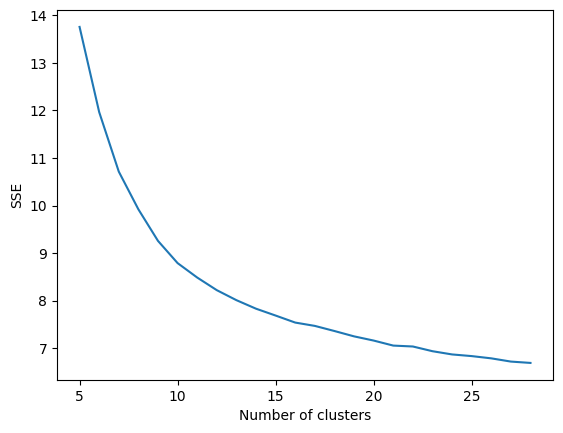

In [195]:
df_shape_based_res.sort_values(by=['inertia'], inplace=True)
# Plot the SSE curve w.r.t. the scaler with the best performance
best_scaler = df_shape_based_res.iloc[0]['scaler']
df_sse_curve = df_shape_based_res[df_shape_based_res['scaler'].apply(lambda x: best_scaler in x)]
df_sse_curve.sort_values(by=['n_centr'], inplace=True)
df_sse_curve.head()
sse_list = df_sse_curve.inertia.values
plt.plot(range(5, len(sse_list) + 5), sse_list)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.savefig(f'timeseries/shape_based_clust/SSE_curve.png')

The best K is 10

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_21612\3580474094.py:2: RuntimeWarning: divide by zero encountered in log
  data = np.log(data.astype('float64'))
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_21612\3580474094.py:2: RuntimeWarning: invalid value encountered in log
  data = np.log(data.astype('float64'))


k=10
 1=122  2=1416  3=636  4=511  5=308  6=394  7=694  8=268  9=1054  10=1384 
Inertia: 8.013325731775792
Silouhette score: 0.1332724412607062
Davies Bouldin score: 1.8258174150415727


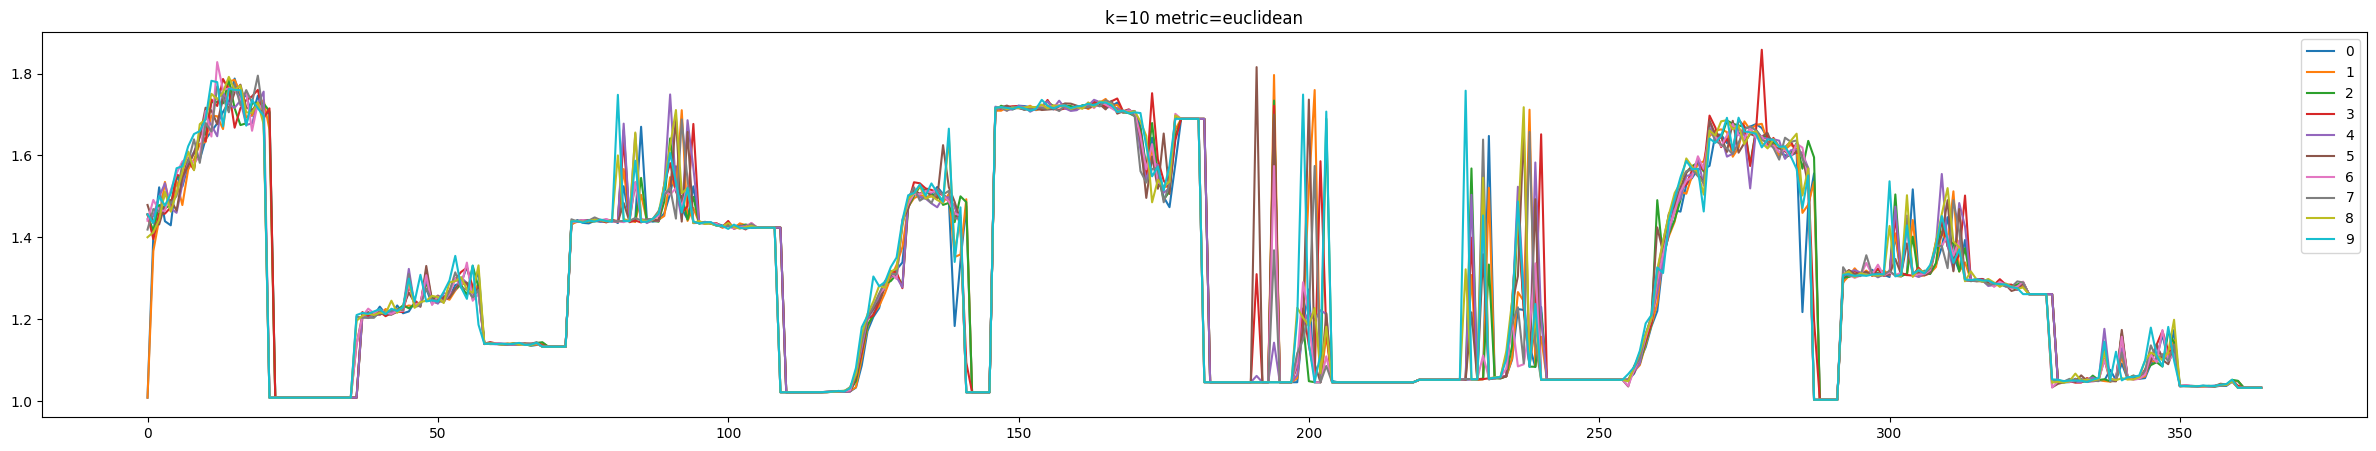

In [196]:
# Re-run timeseries KMeans with the best configuration
k = 10
best_k = df_sse_curve[df_sse_curve['n_centr'] == k]
best_k = best_k.iloc[0]
data = timeseries_list.copy()
logged = to_log(data)
if 'TimeSeriesScalerMinMax' in best_k['scaler']:
    scaled = scale_ts(logged, TimeSeriesScalerMinMax(value_range=(1.0,2.0)))
else:
    scaled = scale_ts(logged, TimeSeriesScalerMeanVariance(mu=0., std=1.))
kmeans = run_ts_kmeans(scaled, n_clust=k, metric=best_k['metrics'], out_path=True, dir='shape_based_clust', log=False)
labels = kmeans.labels_
print(f'Inertia: {kmeans.inertia_}')
get_metrics(scaled, kmeans.labels_)

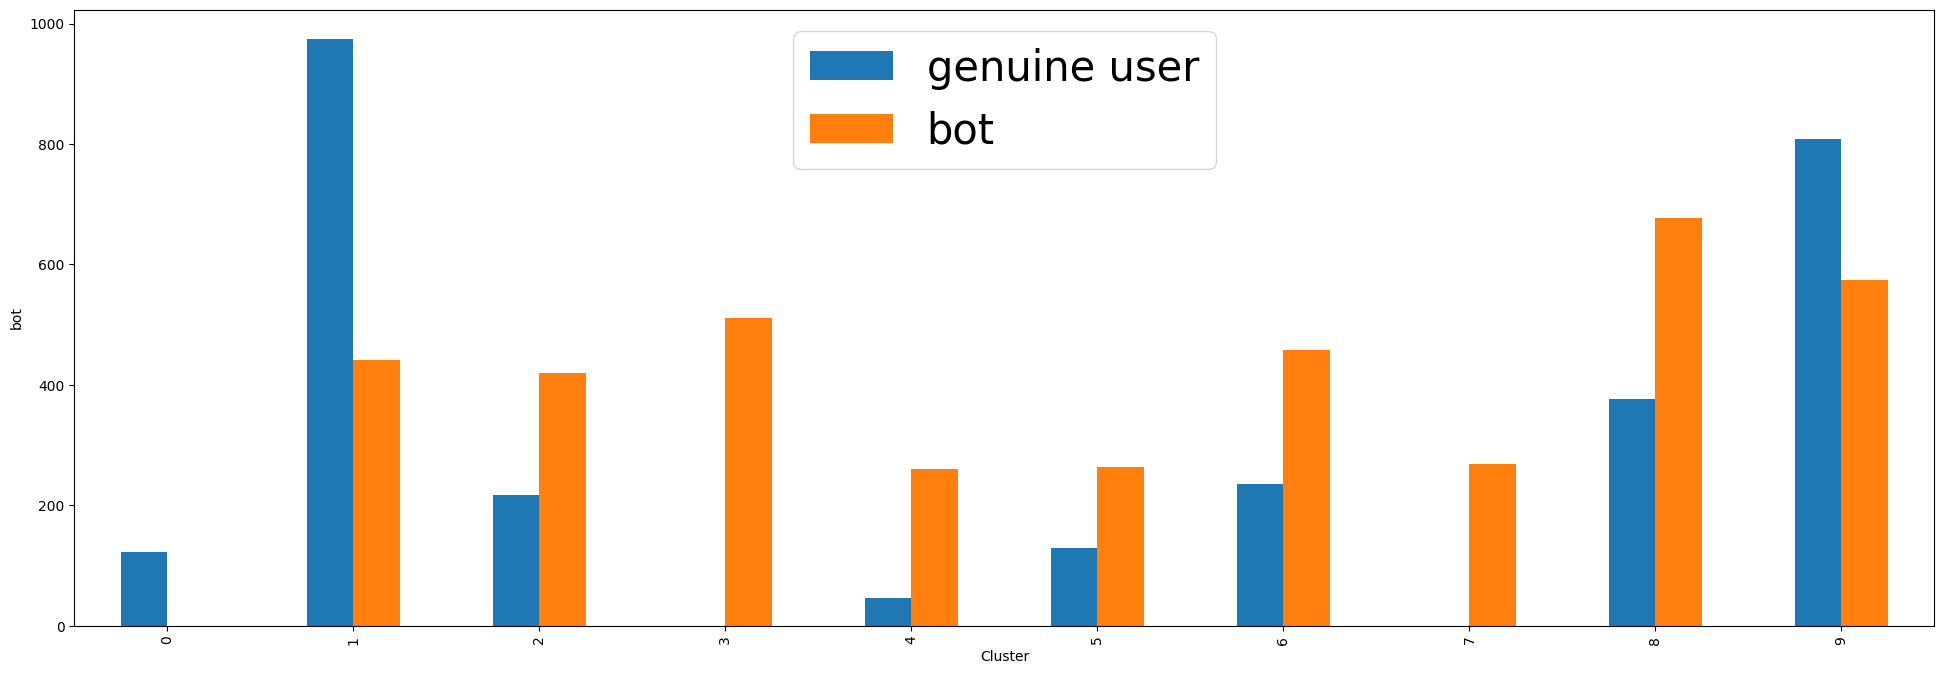

In [198]:
plot_crosstab(labels, df_ts_users.bot, ['genuine user', 'bot'], path=f'timeseries/shape_based_clust')

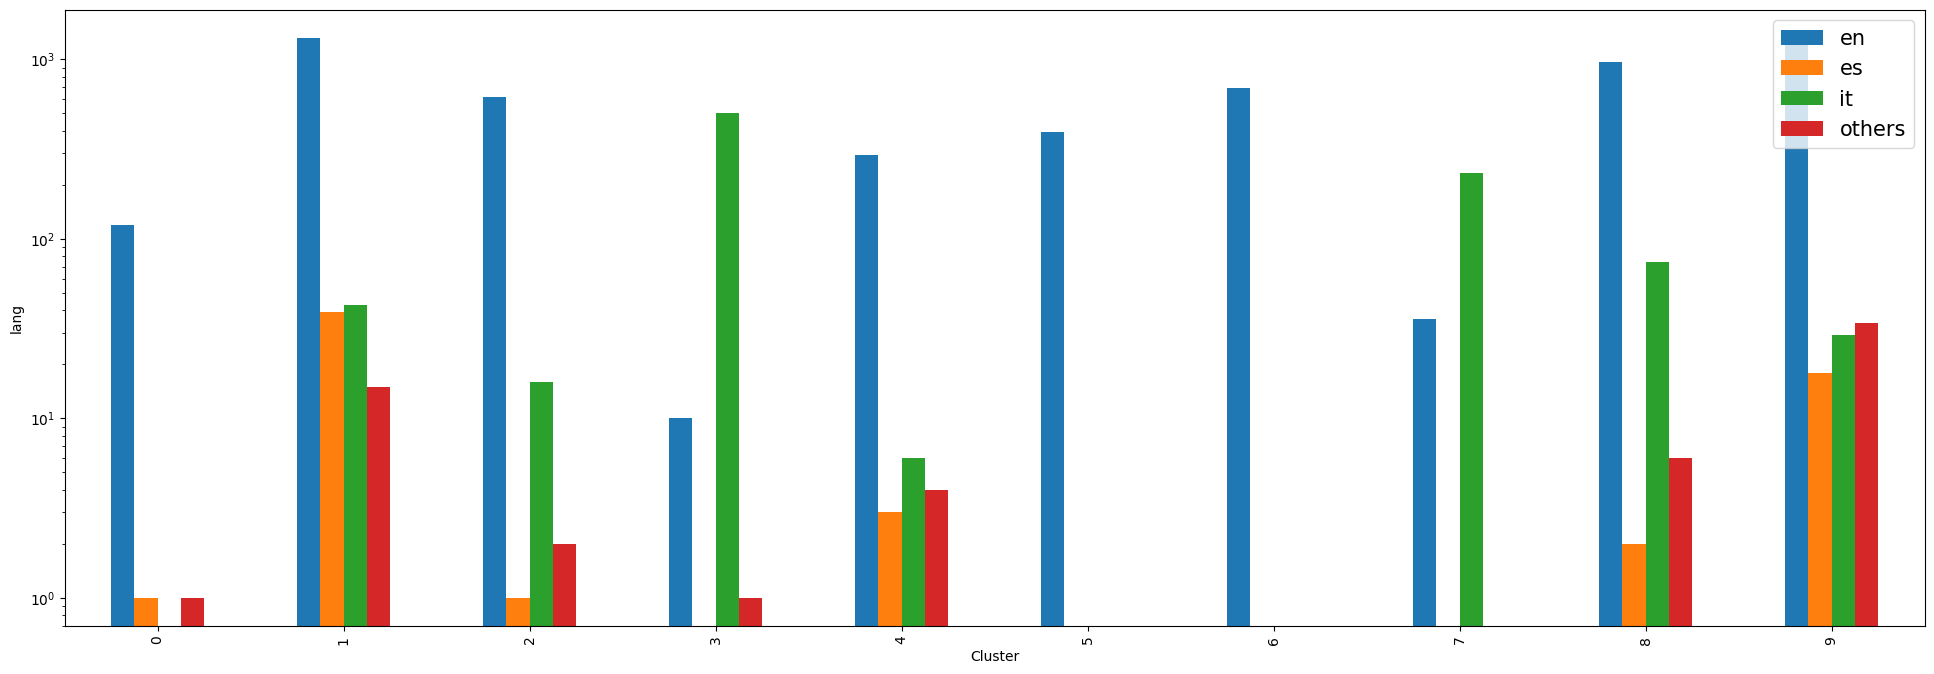

In [199]:
plot_lang_histogram(labels, df_ts_users.lang, out_path=True, path=f'timeseries/shape_based_clust/lang_scatter.png')

# Feature-based clustering

In [200]:
# Extract features from a timeseries in order to perform clustering analysis
def extract_features(values):

    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values),
        'entr': stats.entropy(values)
    }

    return features

In [201]:
n_features = 14
ts_features = np.zeros((0,n_features), dtype=float)
for ts in timeseries_list:
    # Cast all elements from obj to float
    ts_float = np.array([float(elem) for elem in ts])
    ts_features = np.vstack((ts_features, np.array(list(extract_features(ts_float).values()))))

In [182]:
# Create folder
try:
    os.mkdir('timeseries/feature_based_clustering')
except FileExistsError:
    pass

In [103]:
# Feature-based clustering grid search
sse_list = []
min_centr=5
max_centr=50

params = {
    "scaler": [TimeSeriesScalerMeanVariance(mu=0., std=1.),
    TimeSeriesScalerMinMax(value_range=(1., 2.))],
    "metrics": ["euclidean"],
    "n_centr": [i for i in range(min_centr,max_centr+1)],
}

# Perform a cartesian product of the params dict with itself
keys, values = zip(*params.items())
combo_list = list(it.product(*(values)))

res_feature_based = []

#Log data in order to improve performances
data = ts_features.copy()
logged = to_log(data)

for i in tqdm(range(len(combo_list))):

    res_dict = {
        "scaler": combo_list[i][0],
        "metrics" : combo_list[i][1],
        "n_centr" : combo_list[i][2],
    }
    #Scale logged data
    scaled = scale_ts(logged, res_dict['scaler'])
    #Perform kmeans
    kmeans = KMeans(n_clusters=res_dict['n_centr'], n_init=10)
    kmeans.fit(scaled)
    res_dict['inertia'] = kmeans.inertia_
    res_dict['labels'] = kmeans.labels_
    res_dict['centroids'] = kmeans.cluster_centers_

    res_dict['silohuette'], res_dict['DBscore'] = get_metrics(scaled, kmeans.labels_, print_out=False)

    res_feature_based.append(res_dict)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_21612\3580474094.py:2: RuntimeWarning: divide by zero encountered in log
  data = np.log(data.astype('float64'))
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_21612\3580474094.py:2: RuntimeWarning: invalid value encountered in log
  data = np.log(data.astype('float64'))
100%|██████████| 92/92 [04:53<00:00,  3.19s/it]


In [104]:
#Sort results w.r.t. inertia in ascending order
df_feature_based_res = pd.DataFrame(res_feature_based)
df_feature_based_res.sort_values(by=['inertia'], inplace=True, ascending=True)
df_feature_based_res.head()

scaler    metrics  n_centr  \
91  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))  euclidean       50   
90  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))  euclidean       49   
89  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))  euclidean       48   
88  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))  euclidean       47   
87  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))  euclidean       46   

      inertia                                             labels  \
91  83.464196  [0, 0, 14, 29, 2, 25, 20, 0, 32, 14, 48, 32, 1...   
90  83.946003  [1, 1, 31, 33, 2, 47, 13, 1, 12, 31, 4, 12, 18...   
89  86.300931  [22, 22, 23, 3, 26, 2, 44, 22, 34, 23, 12, 34,...   
88  87.049551  [7, 7, 42, 3, 21, 18, 29, 7, 33, 42, 8, 33, 15...   
87  89.590917  [20, 20, 7, 12, 0, 8, 40, 20, 2, 7, 29, 2, 44,...   

                                            centroids  silohuette   DBscore  
91  [[1.2432447615637678, 1.2155830292678502, 1.0,...    0.440125  0.886353  
90  [[1.3916120292728094, 1.6105172308571138, 2.0,...    0.437292  0.923650  
89  [[1.315795131916966, 1.2506934038417052, 1.0, ...    0.438219  0.896366  
88  [[1.513578884805904, 1.5432554177286972, 2.0, ...    0.443588  0.894085  
87  [[1.0013630932739954, 1.0967095984761301, 1.03...    0.442687  0.885043

In [105]:
df_feature_based_res.to_csv(DATA_PATH+'feature_based_results.csv', sep='#')

In [202]:
df_feature_based_res = pd.read_csv(DATA_PATH+'feature_based_results.csv', sep='#')

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_21612\1906516479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sse_curve.sort_values(by=['n_centr'], inplace=True)


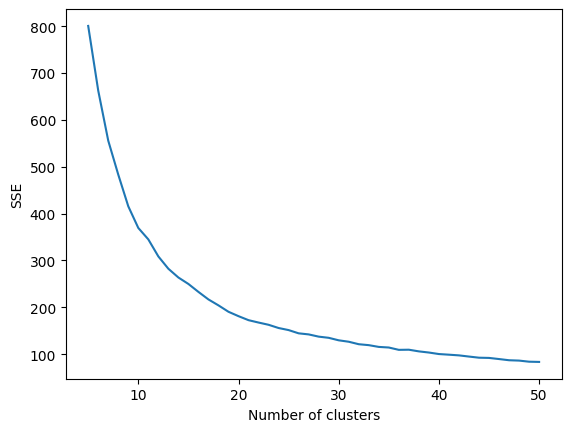

In [203]:
#Plot the SSE curve w.r.t. the scaler with the best performance
best_scaler = df_feature_based_res.iloc[0]['scaler']
df_sse_curve = df_feature_based_res[df_feature_based_res['scaler'].apply(lambda x: best_scaler in x)]
df_sse_curve.sort_values(by=['n_centr'], inplace=True)
sse_list = df_sse_curve.inertia.values
plt.plot(range(5, len(sse_list) + 5), sse_list)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.savefig(f'timeseries/feature_based_clustering/SSE_curve.png')
plt.show()

In this case the optimal k seems to be 12

In [204]:
# Re-run KMeans with the best configuration
k = 12
best_k = df_sse_curve[df_sse_curve['n_centr'] == k]
best_k = best_k.iloc[0]
data = ts_features.copy()
logged = to_log(data)
if 'TimeSeriesScalerMinMax' in best_k['scaler']:
    scaled = scale_ts(logged, TimeSeriesScalerMinMax(value_range=(1.0,2.0)))
else:
    scaled = scale_ts(logged, TimeSeriesScalerMeanVariance(mu=0., std=1.))
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(scaled)
labels = kmeans.labels_
print(f'Inertia: {kmeans.inertia_}')
get_metrics(scaled, kmeans.labels_)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_21612\3580474094.py:2: RuntimeWarning: divide by zero encountered in log
  data = np.log(data.astype('float64'))
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_21612\3580474094.py:2: RuntimeWarning: invalid value encountered in log
  data = np.log(data.astype('float64'))


Inertia: 310.2358921282786
Silouhette score: 0.46736500323703506
Davies Bouldin score: 0.8343285737207142


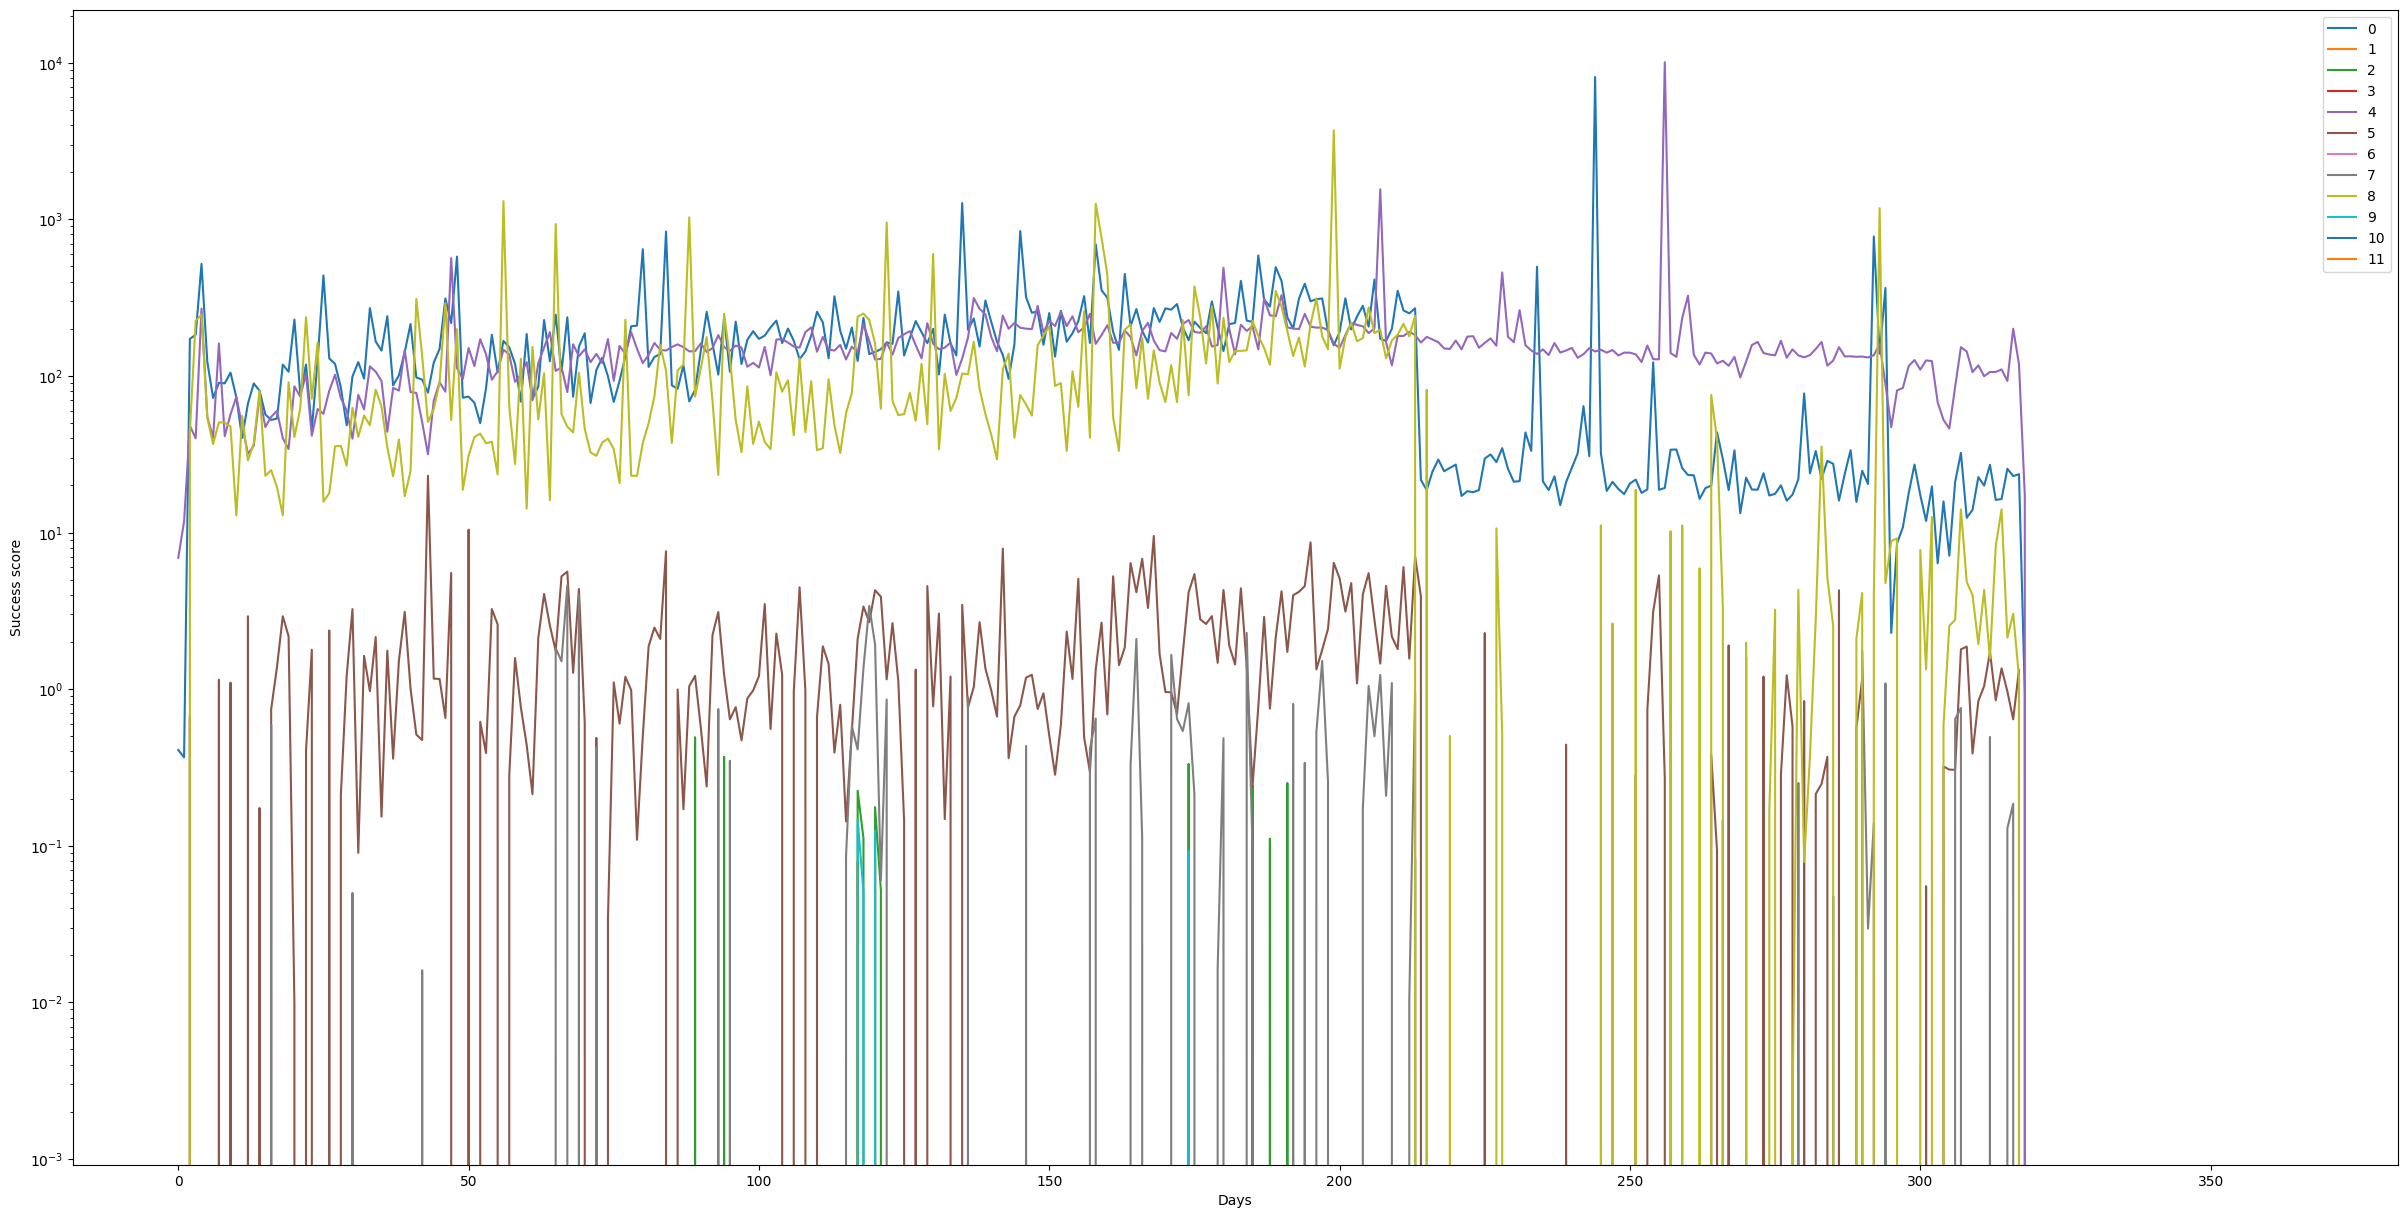

In [112]:
# Get unique labels
unique_labels = np.unique(kmeans.labels_)

plt.figure(figsize=(30,15))
for i in range(len(unique_labels)):
    plt.plot(np.mean(timeseries_list[np.where(kmeans.labels_ == i)[0]], axis=0))

plt.ylabel('Success score')
plt.xlabel('Days')
plt.yscale('log')
plt.legend(labels=unique_labels, loc="upper right")
plt.show()

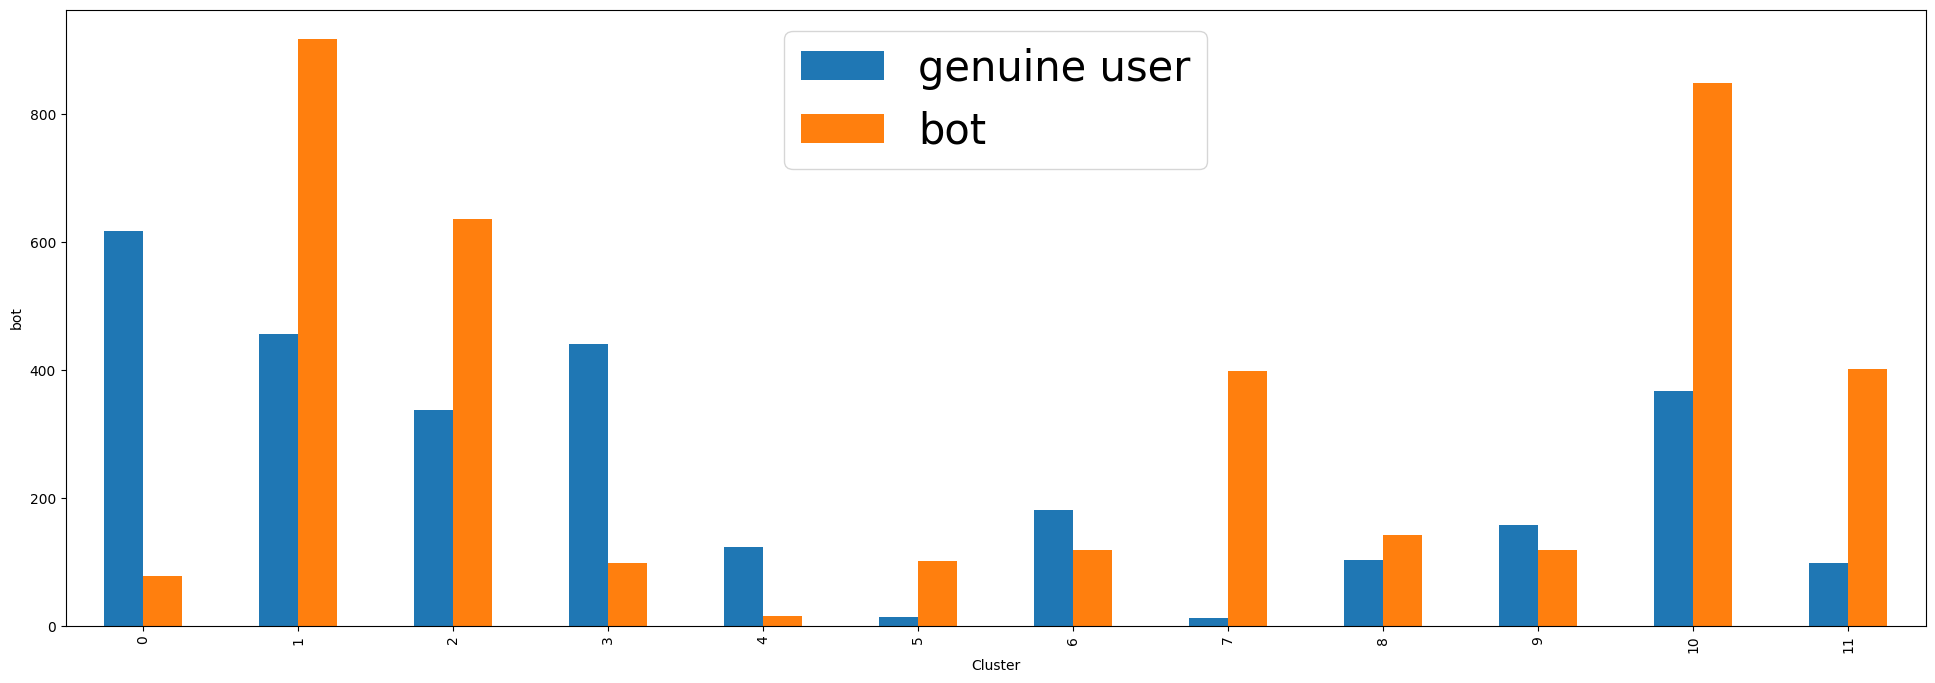

In [205]:
plot_crosstab(labels, df_ts_users.bot, ['genuine user', 'bot'], path=f'timeseries/feature_based_clustering/')

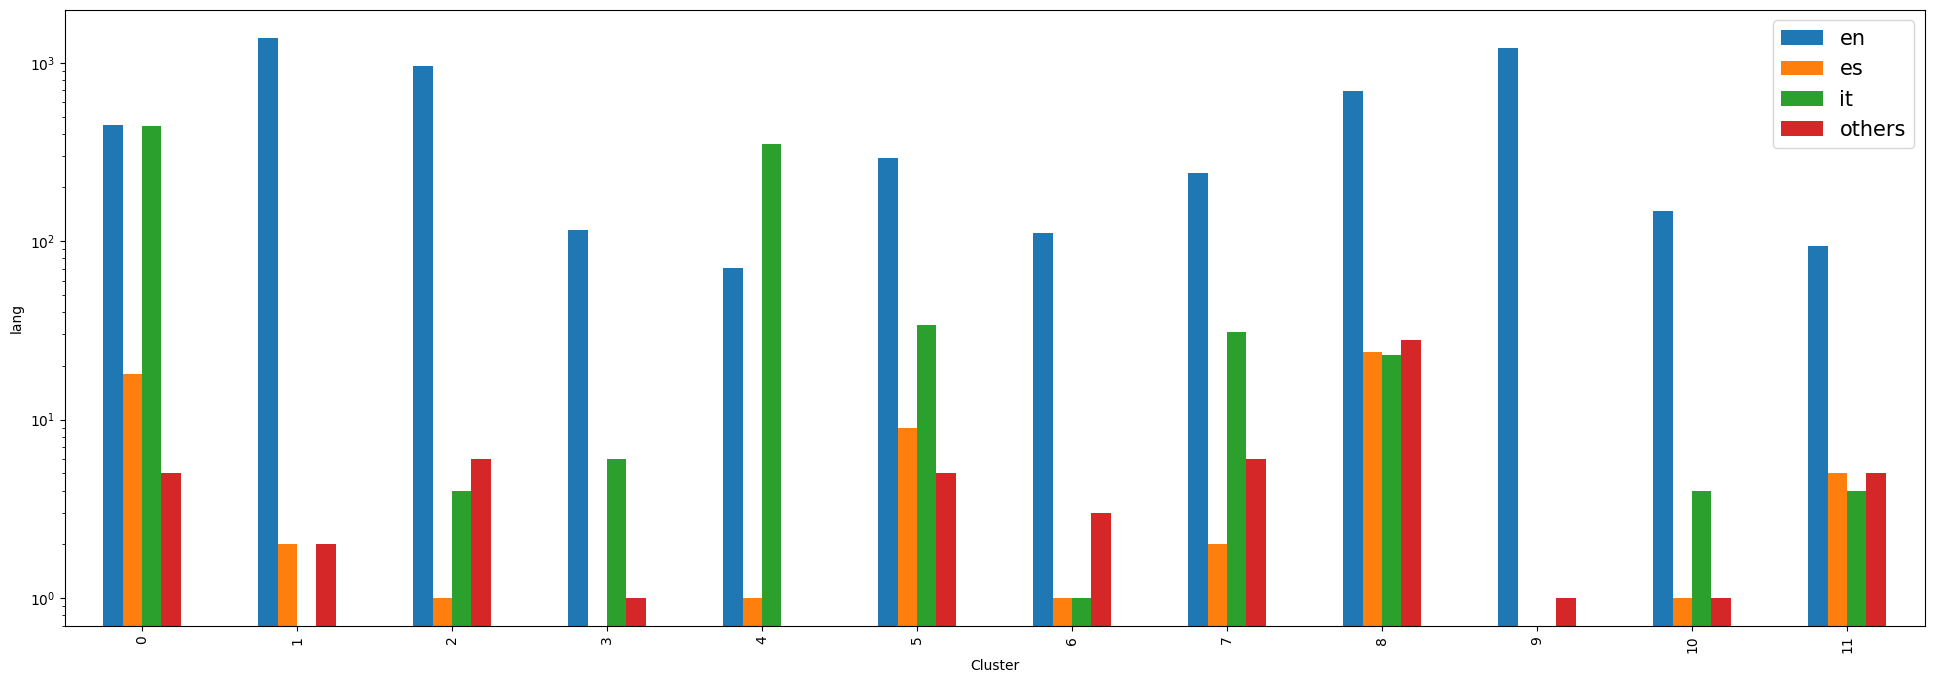

In [114]:
plot_lang_histogram(labels, df_ts_users.lang, out_path=True, path=f'timeseries/feature_based_clustering/lang_scatter.png')

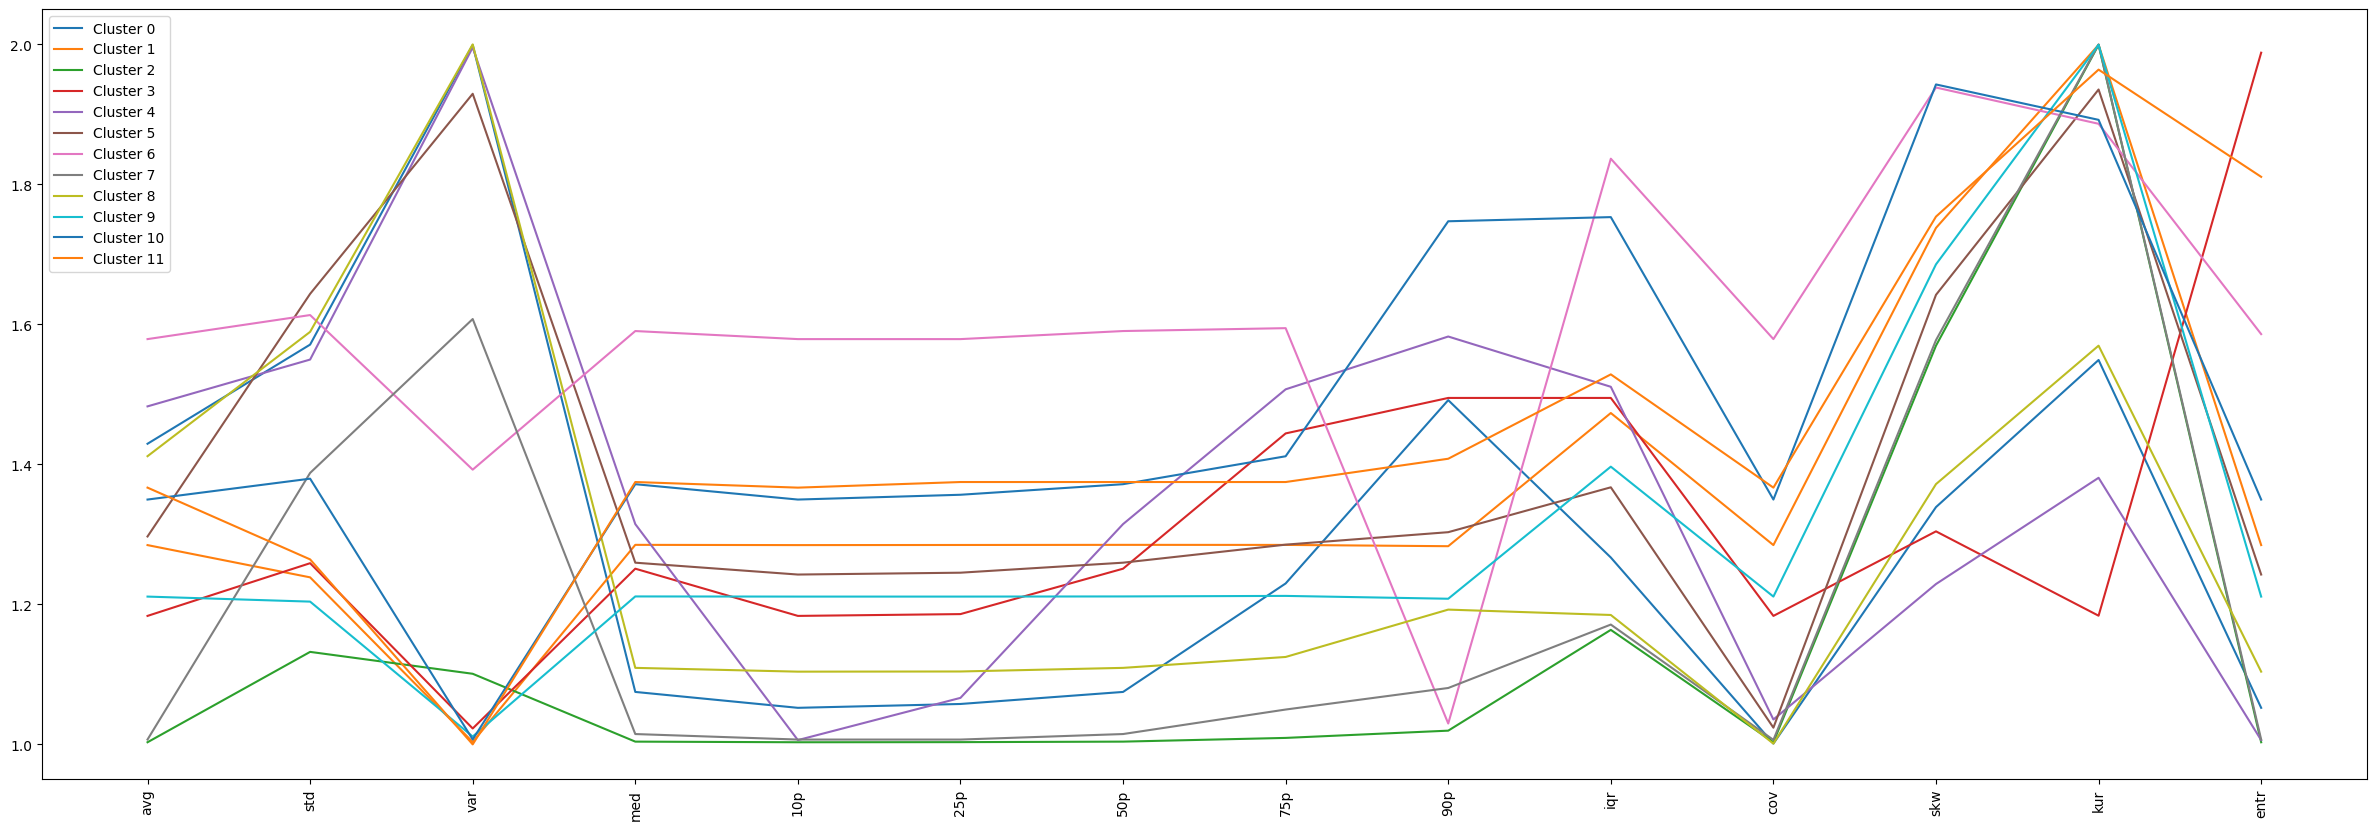

In [115]:
df_best_feature_based = pd.DataFrame(scaled, columns=['avg', 'std', 'var', 'med', '10p', '25p', '50p', '75p', '90p', 'iqr', 'cov', 'skw', 'kur', 'entr'])
from clusteringUtilities import plot_landscape
plot_landscape(kmeans.labels_, kmeans.cluster_centers_, df_best_feature_based, path='timeseries/feature_based_clustering', figsize=(30,10))

# Compression-based clustering

In [ ]:
# Create folder
import os

try: 
    os.mkdir('timeseries/compression_based_clustering')
except FileExistsError:
    pass

In [212]:
# Compression-based clustering grid search
min_centr = 2
max_centr = 25

params = {
    "scaler": [TimeSeriesScalerMeanVariance(mu=0., std=1.),
    TimeSeriesScalerMinMax(value_range=(1., 2.))],
    "n_segments": [10,50,100,200,250],
    "n_centr": [i for i in range(min_centr,max_centr+1)],
    "metrics": ["euclidean"]
}

keys, values = zip(*params.items())
combo_list = list(it.product(*(values)))

compression_based_res = []

data = timeseries_list.copy()
# Log data in order to improve performances
logged = to_log(data)

for i in tqdm(range(len(combo_list))):

    res_dict = {
        "scaler": combo_list[i][0],
        "n_segments": combo_list[i][1],
        "n_centr" : combo_list[i][2],
        "metrics" : combo_list[i][3],
    }

    # Scale logged data
    scaled = scale_ts(logged, res_dict['scaler'])

    paa = PiecewiseAggregateApproximation(n_segments=res_dict['n_segments'])
    ts_paa = paa.fit_transform(scaled)

    # Perform kmeans
    kmeans = run_ts_kmeans(ts_paa, n_clust=res_dict["n_centr"], metric=res_dict["metrics"], out_path=False, dir='compression_based_clustering', scaler_name=res_dict['scaler'])

    # Save centroids, labels and scores in a dict
    res_dict['labels'] = kmeans.labels_
    res_dict['inertia'] = kmeans.inertia_
    res_dict['centroids'] = kmeans.cluster_centers_

    res_dict['silohuette'], res_dict['DBscore'] = get_metrics(scaled, kmeans.labels_, print_out=False)

    compression_based_res.append(res_dict)


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_27352\3580474094.py:2: RuntimeWarning: divide by zero encountered in log
  data = np.log(data.astype('float64'))
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_27352\3580474094.py:2: RuntimeWarning: invalid value encountered in log
  data = np.log(data.astype('float64'))
  0%|          | 0/240 [00:00<?, ?it/s]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=2
 1=5939  2=848 


  0%|          | 1/240 [00:29<1:58:31, 29.76s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=3
 1=4219  2=847  3=1721 


  1%|          | 2/240 [01:00<2:00:11, 30.30s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=4
 1=4198  2=567  3=1694  4=328 


  1%|▏         | 3/240 [01:42<2:21:08, 35.73s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=5
 1=4063  2=1136  3=566  4=324  5=698 


  2%|▏         | 4/240 [02:42<2:58:15, 45.32s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=6
 1=3799  2=566  3=1098  4=324  5=695  6=305 


  2%|▏         | 5/240 [03:44<3:20:24, 51.17s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=7
 1=1073  2=324  3=3709  4=566  5=665  6=229  7=221 


  2%|▎         | 6/240 [04:47<3:35:09, 55.17s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=8
 1=229  2=566  3=668  4=3721  5=221  6=267  7=950  8=165 


  3%|▎         | 7/240 [05:50<3:45:07, 57.97s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=9
 1=684  2=563  3=687  4=341  5=267  6=222  7=227  8=160  9=3636 


  3%|▎         | 8/240 [07:19<4:21:27, 67.62s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=10
 1=3591  2=561  3=453  4=457  5=219  6=266  7=347  8=158  9=517  10=218 


  4%|▍         | 9/240 [08:54<4:53:09, 76.15s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=11
 1=3652  2=257  3=668  4=647  5=161  6=221  7=229  8=342  9=265  10=43  11=302 


  4%|▍         | 10/240 [10:24<5:08:19, 80.43s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=12
 1=1668  2=255  3=265  4=512  5=307  6=192  7=445  8=390  9=2045  10=348  11=201  12=159 


  5%|▍         | 11/240 [12:22<5:51:27, 92.08s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=13
 1=416  2=1633  3=302  4=159  5=163  6=466  7=336  8=209  9=2105  10=258  11=41  12=262  13=437 


  5%|▌         | 12/240 [14:05<6:02:42, 95.45s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=14
 1=443  2=2104  3=258  4=1635  5=134  6=467  7=336  8=163  9=41  10=302  11=211  12=138  13=151  14=404 


  5%|▌         | 13/240 [16:00<6:22:42, 101.16s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=15
 1=2028  2=257  3=411  4=484  5=151  6=139  7=117  8=302  9=1671  10=434  11=179  12=115  13=41  14=133  15=325 


  6%|▌         | 14/240 [17:53<6:35:05, 104.89s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=16
 1=1700  2=302  3=389  4=323  5=134  6=1977  7=257  8=356  9=116  10=180  11=326  12=113  13=138  14=284  15=151  16=41 


  6%|▋         | 15/240 [19:34<6:29:16, 103.81s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=17
 1=1415  2=257  3=337  4=244  5=349  6=41  7=437  8=138  9=302  10=117  11=151  12=310  13=133  14=108  15=1192  16=173  17=1083 


  7%|▋         | 16/240 [21:21<6:30:17, 104.54s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=18
 1=248  2=1419  3=257  4=331  5=385  6=151  7=138  8=181  9=118  10=326  11=1103  12=256  13=133  14=108  15=163  16=41  17=302  18=1127 


  7%|▋         | 17/240 [23:06<6:29:09, 104.71s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=19
 1=151  2=1132  3=302  4=294  5=1131  6=133  7=175  8=275  9=154  10=257  11=138  12=263  13=37  14=115  15=361  16=1403  17=190  18=168  19=108 


  8%|▊         | 18/240 [25:16<6:56:15, 112.50s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=20
 1=1175  2=303  3=377  4=91  5=120  6=37  7=1093  8=257  9=1364  10=79  11=387  12=108  13=100  14=104  15=331  16=130  17=221  18=131  19=199  20=180 


  8%|▊         | 19/240 [26:54<6:38:28, 108.18s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=21
 1=257  2=988  3=254  4=120  5=173  6=91  7=325  8=97  9=344  10=188  11=40  12=1192  13=107  14=110  15=97  16=303  17=197  18=79  19=1361  20=131  21=333 


  8%|▊         | 20/240 [28:45<6:38:48, 108.77s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=22
 1=132  2=1179  3=303  4=339  5=214  6=81  7=100  8=162  9=257  10=1367  11=340  12=1058  13=107  14=68  15=37  16=156  17=150  18=186  19=124  20=99  21=96  22=232 


  9%|▉         | 21/240 [30:50<6:55:37, 113.87s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=23
 1=1214  2=302  3=231  4=340  5=288  6=151  7=132  8=147  9=106  10=138  11=257  12=81  13=94  14=1015  15=244  16=36  17=150  18=91  19=91  20=572  21=134  22=143  23=830 


  9%|▉         | 22/240 [32:38<6:46:39, 111.92s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=24
 1=1190  2=8  3=249  4=34  5=119  6=214  7=182  8=91  9=167  10=108  11=99  12=302  13=131  14=1087  15=162  16=100  17=146  18=257  19=1324  20=235  21=79  22=62  23=350  24=91 


 10%|▉         | 23/240 [34:16<6:29:48, 107.78s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=25
 1=448  2=303  3=226  4=72  5=987  6=104  7=176  8=103  9=141  10=257  11=120  12=100  13=93  14=787  15=131  16=36  17=152  18=220  19=1018  20=277  21=173  22=169  23=178  24=98  25=418 


 10%|█         | 24/240 [36:05<6:29:16, 108.13s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=2
 1=859  2=5928 


 10%|█         | 25/240 [36:38<5:07:10, 85.72s/it] c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=3
 1=3888  2=861  3=2038 


 11%|█         | 26/240 [37:12<4:10:11, 70.15s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=4
 1=571  2=3883  3=2004  4=329 


 11%|█▏        | 27/240 [38:18<4:04:21, 68.83s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=5
 1=3504  2=571  3=1889  4=327  5=496 


 12%|█▏        | 28/240 [39:12<3:47:17, 64.33s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=6
 1=327  2=2079  3=570  4=489  5=1878  6=1444 


 12%|█▏        | 29/240 [40:17<3:47:34, 64.71s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=7
 1=413  2=2066  3=1234  4=320  5=1378  6=568  7=808 


 12%|█▎        | 30/240 [42:00<4:26:45, 76.22s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=8
 1=408  2=1381  3=565  4=884  5=349  6=314  7=828  8=2058 


 13%|█▎        | 31/240 [43:10<4:19:05, 74.38s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=9
 1=297  2=313  3=2067  4=565  5=1362  6=861  7=721  8=254  9=347 


 13%|█▎        | 32/240 [44:41<4:34:21, 79.14s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=10
 1=1357  2=565  3=773  4=297  5=2061  6=269  7=338  8=160  9=722  10=245 


 14%|█▍        | 33/240 [45:56<4:29:01, 77.98s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=11
 1=244  2=314  3=296  4=774  5=265  6=337  7=2063  8=724  9=163  10=253  11=1354 


 14%|█▍        | 34/240 [47:36<4:50:49, 84.71s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=12
 1=2057  2=245  3=684  4=306  5=332  6=284  7=164  8=34  9=265  10=1361  11=255  12=800 


 15%|█▍        | 35/240 [49:06<4:54:58, 86.33s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=13
 1=32  2=559  3=93  4=280  5=673  6=301  7=1029  8=335  9=1102  10=262  11=1279  12=185  13=657 


 15%|█▌        | 36/240 [50:55<5:16:13, 93.01s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=14
 1=104  2=559  3=546  4=1126  5=1274  6=1012  7=32  8=606  9=267  10=333  11=161  12=256  13=191  14=320 


 15%|█▌        | 37/240 [52:48<5:35:17, 99.10s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=15
 1=32  2=1012  3=490  4=559  5=268  6=564  7=558  8=1061  9=792  10=245  11=160  12=335  13=420  14=181  15=110 


 16%|█▌        | 38/240 [54:40<5:46:41, 102.98s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=16
 1=1087  2=556  3=254  4=447  5=788  6=268  7=529  8=32  9=305  10=110  11=161  12=176  13=336  14=238  15=985  16=515 


 16%|█▋        | 39/240 [56:57<6:18:25, 112.96s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=17
 1=222  2=782  3=101  4=32  5=348  6=336  7=1064  8=435  9=163  10=265  11=561  12=1008  13=286  14=305  15=444  16=181  17=254 


 17%|█▋        | 40/240 [58:31<5:57:42, 107.31s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=18
 1=32  2=144  3=308  4=981  5=305  6=398  7=209  8=336  9=1095  10=342  11=132  12=93  13=559  14=256  15=779  16=493  17=175  18=150 


 17%|█▋        | 41/240 [1:00:26<6:03:20, 109.55s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=19
 1=1277  2=256  3=263  4=150  5=210  6=1095  7=32  8=193  9=130  10=91  11=305  12=161  13=151  14=156  15=454  16=409  17=142  18=277  19=1035 


 18%|█▊        | 42/240 [1:02:17<6:03:21, 110.11s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=20
 1=976  2=255  3=246  4=228  5=32  6=202  7=305  8=436  9=142  10=337  11=553  12=132  13=788  14=1094  15=295  16=98  17=261  18=149  19=93  20=165 


 18%|█▊        | 43/240 [1:04:26<6:20:34, 115.91s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=21
 1=592  2=305  3=534  4=503  5=310  6=142  7=302  8=255  9=415  10=137  11=135  12=745  13=465  14=89  15=436  16=32  17=336  18=209  19=85  20=149  21=611 


 18%|█▊        | 44/240 [1:06:37<6:32:46, 120.24s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=22
 1=177  2=258  3=1089  4=95  5=270  6=788  7=129  8=361  9=151  10=81  11=140  12=334  13=120  14=116  15=186  16=549  17=968  18=303  19=143  20=208  21=32  22=289 


 19%|█▉        | 45/240 [1:08:28<6:21:35, 117.41s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=23
 1=567  2=303  3=336  4=503  5=261  6=276  7=196  8=593  9=424  10=257  11=141  12=82  13=248  14=427  15=133  16=149  17=81  18=578  19=31  20=132  21=257  22=752  23=60 


 19%|█▉        | 46/240 [1:10:29<6:23:25, 118.59s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=24
 1=55  2=593  3=303  4=770  5=392  6=258  7=117  8=334  9=257  10=132  11=141  12=377  13=108  14=133  15=62  16=771  17=201  18=119  19=729  20=32  21=120  22=116  23=519  24=148 


 20%|█▉        | 47/240 [1:12:33<6:27:03, 120.33s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=25
 1=98  2=627  3=303  4=424  5=161  6=131  7=884  8=402  9=141  10=148  11=99  12=162  13=32  14=260  15=121  16=704  17=82  18=257  19=51  20=124  21=405  22=753  23=213  24=76  25=129 


 20%|██        | 48/240 [1:15:00<6:50:30, 128.28s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=2
 1=5952  2=835 


 20%|██        | 49/240 [1:15:40<5:24:01, 101.79s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=3
 1=832  2=2459  3=3496 


 21%|██        | 50/240 [1:16:26<4:29:34, 85.13s/it] c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=4
 1=835  2=1311  3=2407  4=2234 


 21%|██▏       | 51/240 [1:17:31<4:08:25, 78.87s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=5
 1=994  2=816  3=580  4=1998  5=2399 


 22%|██▏       | 52/240 [1:18:27<3:46:13, 72.20s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=6
 1=304  2=993  3=2398  4=1988  5=569  6=535 


 22%|██▏       | 53/240 [1:19:53<3:57:30, 76.21s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=7
 1=986  2=1987  3=569  4=1017  5=304  6=530  7=1394 


 22%|██▎       | 54/240 [1:21:11<3:57:50, 76.72s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=8
 1=1300  2=1407  3=1002  4=830  5=985  6=565  7=275  8=423 


 23%|██▎       | 55/240 [1:22:34<4:02:39, 78.70s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=9
 1=242  2=319  3=1416  4=565  5=1251  6=995  7=984  8=275  9=740 


 23%|██▎       | 56/240 [1:24:24<4:30:08, 88.09s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=10
 1=216  2=985  3=562  4=1227  5=920  6=337  7=320  8=1177  9=770  10=273 


 24%|██▍       | 57/240 [1:25:52<4:28:52, 88.16s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=11
 1=845  2=791  3=562  4=273  5=319  6=768  7=913  8=237  9=783  10=975  11=321 


 24%|██▍       | 58/240 [1:27:29<4:35:23, 90.79s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=12
 1=762  2=562  3=111  4=968  5=319  6=906  7=914  8=738  9=272  10=273  11=196  12=766 


 25%|██▍       | 59/240 [1:29:16<4:48:20, 95.58s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=13
 1=760  2=305  3=916  4=770  5=574  6=304  7=272  8=242  9=258  10=319  11=791  12=859  13=417 


 25%|██▌       | 60/240 [1:30:56<4:50:18, 96.77s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=14
 1=838  2=761  3=112  4=305  5=254  6=803  7=268  8=187  9=322  10=352  11=257  12=970  13=713  14=645 


 25%|██▌       | 61/240 [1:32:42<4:57:05, 99.59s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=15
 1=187  2=844  3=256  4=669  5=251  6=777  7=407  8=268  9=775  10=574  11=325  12=384  13=109  14=656  15=305 


 26%|██▌       | 62/240 [1:34:43<5:14:40, 106.07s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=16
 1=189  2=731  3=269  4=395  5=465  6=630  7=411  8=637  9=505  10=321  11=99  12=248  13=561  14=568  15=569  16=189 


 26%|██▋       | 63/240 [1:36:32<5:15:28, 106.94s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=17
 1=474  2=305  3=655  4=444  5=324  6=645  7=412  8=109  9=404  10=257  11=428  12=671  13=249  14=388  15=187  16=268  17=567 


 27%|██▋       | 64/240 [1:38:23<5:17:06, 108.11s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=18
 1=305  2=577  3=319  4=484  5=407  6=152  7=402  8=571  9=112  10=450  11=185  12=748  13=132  14=273  15=62  16=257  17=497  18=854 


 27%|██▋       | 65/240 [1:40:27<5:29:27, 112.96s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=19
 1=530  2=304  3=462  4=511  5=266  6=109  7=425  8=376  9=181  10=567  11=305  12=534  13=325  14=511  15=58  16=232  17=411  18=424  19=256 


 28%|██▊       | 66/240 [1:42:13<5:21:22, 110.82s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=20
 1=304  2=792  3=99  4=323  5=834  6=764  7=257  8=133  9=410  10=442  11=572  12=442  13=159  14=424  15=149  16=28  17=54  18=323  19=147  20=131 


 28%|██▊       | 67/240 [1:44:17<5:31:08, 114.84s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=21
 1=729  2=303  3=455  4=124  5=131  6=562  7=123  8=168  9=256  10=222  11=227  12=295  13=452  14=650  15=147  16=368  17=65  18=322  19=424  20=460  21=304 


 28%|██▊       | 68/240 [1:46:19<5:35:27, 117.02s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=22
 1=207  2=307  3=154  4=257  5=332  6=399  7=538  8=199  9=407  10=410  11=264  12=95  13=566  14=311  15=304  16=326  17=140  18=378  19=194  20=380  21=409  22=210 


 29%|██▉       | 69/240 [1:48:30<5:44:57, 121.04s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=23
 1=391  2=303  3=442  4=433  5=520  6=139  7=146  8=167  9=324  10=314  11=174  12=404  13=134  14=466  15=258  16=349  17=132  18=194  19=434  20=94  21=325  22=242  23=402 


 29%|██▉       | 70/240 [1:50:41<5:51:39, 124.11s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=24
 1=45  2=412  3=267  4=723  5=303  6=210  7=565  8=264  9=466  10=149  11=636  12=195  13=254  14=118  15=155  16=137  17=186  18=565  19=125  20=95  21=258  22=30  23=383  24=246 


 30%|██▉       | 71/240 [1:52:45<5:49:13, 123.99s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=25
 1=150  2=559  3=323  4=258  5=269  6=133  7=729  8=187  9=147  10=656  11=344  12=185  13=163  14=258  15=45  16=443  17=144  18=303  19=144  20=28  21=96  22=309  23=213  24=427  25=274 


 30%|███       | 72/240 [1:55:00<5:56:32, 127.33s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=2
 1=4410  2=2377 


 30%|███       | 73/240 [1:55:42<4:43:45, 101.95s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=3
 1=972  2=3438  3=2377 


 31%|███       | 74/240 [1:56:28<3:54:55, 84.91s/it] c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=4
 1=1157  2=975  3=2384  4=2271 


 31%|███▏      | 75/240 [1:57:19<3:25:29, 74.72s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=5
 1=831  2=974  3=1156  4=1559  5=2267 


 32%|███▏      | 76/240 [1:58:10<3:04:53, 67.65s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=6
 1=2067  2=833  3=733  4=973  5=623  6=1558 


 32%|███▏      | 77/240 [1:59:11<2:58:32, 65.72s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=7
 1=833  2=646  3=2058  4=1161  5=410  6=973  7=706 


 32%|███▎      | 78/240 [2:00:21<3:01:18, 67.15s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=8
 1=740  2=604  3=832  4=738  5=1161  6=236  7=410  8=2066 


 33%|███▎      | 79/240 [2:01:28<2:59:33, 66.92s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=9
 1=833  2=608  3=230  4=2063  5=1163  6=740  7=591  8=155  9=404 


 33%|███▎      | 80/240 [2:02:40<3:02:50, 68.57s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=10
 1=291  2=579  3=235  4=706  5=844  6=639  7=1067  8=1292  9=397  10=737 


 34%|███▍      | 81/240 [2:03:50<3:02:27, 68.85s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=11
 1=567  2=400  3=236  4=828  5=148  6=1257  7=814  8=203  9=1162  10=738  11=434 


 34%|███▍      | 82/240 [2:05:12<3:12:10, 72.98s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=12
 1=236  2=596  3=713  4=404  5=1364  6=560  7=217  8=589  9=745  10=477  11=737  12=149 


 35%|███▍      | 83/240 [2:06:50<3:30:03, 80.28s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=13
 1=1  2=1331  3=569  4=397  5=738  6=504  7=250  8=620  9=492  10=629  11=236  12=265  13=755 


 35%|███▌      | 84/240 [2:08:09<3:27:47, 79.92s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=14
 1=738  2=528  3=158  4=392  5=1  6=390  7=2032  8=375  9=468  10=573  11=236  12=402  13=216  14=278 


 35%|███▌      | 85/240 [2:09:35<3:31:20, 81.81s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=15
 1=279  2=526  3=573  4=237  5=416  6=239  7=247  8=463  9=2002  10=394  11=738  12=30  13=293  14=137  15=213 


 36%|███▌      | 86/240 [2:11:05<3:36:09, 84.22s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=16
 1=589  2=528  3=164  4=393  5=1  6=241  7=2033  8=478  9=150  10=573  11=155  12=274  13=355  14=279  15=230  16=344 


 36%|███▋      | 87/240 [2:12:36<3:40:22, 86.42s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=17
 1=563  2=423  3=500  4=382  5=250  6=386  7=630  8=353  9=384  10=1129  11=148  12=246  13=472  14=222  15=223  16=230  17=246 


 37%|███▋      | 88/240 [2:14:08<3:43:11, 88.10s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=18
 1=239  2=1203  3=376  4=30  5=223  6=383  7=488  8=615  9=363  10=564  11=123  12=255  13=142  14=109  15=879  16=242  17=183  18=370 


 37%|███▋      | 89/240 [2:15:33<3:39:09, 87.09s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=19
 1=47  2=573  3=139  4=245  5=300  6=343  7=201  8=361  9=221  10=159  11=223  12=220  13=617  14=177  15=236  16=217  17=258  18=305  19=1945 


 38%|███▊      | 90/240 [2:16:55<3:34:10, 85.67s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=20
 1=220  2=273  3=573  4=217  5=205  6=297  7=189  8=531  9=2004  10=178  11=30  12=178  13=148  14=209  15=383  16=205  17=143  18=267  19=183  20=354 


 38%|███▊      | 91/240 [2:18:21<3:32:32, 85.59s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=21
 1=856  2=1222  3=290  4=119  5=390  6=215  7=354  8=23  9=215  10=281  11=150  12=257  13=564  14=280  15=133  16=498  17=266  18=150  19=208  20=209  21=107 


 38%|███▊      | 92/240 [2:19:57<3:38:47, 88.70s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=22
 1=238  2=219  3=569  4=249  5=245  6=288  7=736  8=392  9=153  10=1325  11=117  12=309  13=180  14=331  15=132  16=262  17=298  18=143  19=146  20=246  21=184  22=25 


 39%|███▉      | 93/240 [2:21:32<3:42:23, 90.77s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=23
 1=1321  2=132  3=148  4=320  5=569  6=214  7=219  8=240  9=375  10=258  11=264  12=91  13=148  14=225  15=319  16=223  17=234  18=747  19=170  20=61  21=111  22=273  23=125 


 39%|███▉      | 94/240 [2:23:06<3:42:42, 91.52s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=24
 1=47  2=172  3=388  4=235  5=68  6=198  7=531  8=1949  9=365  10=179  11=256  12=123  13=182  14=208  15=111  16=184  17=345  18=142  19=177  20=188  21=226  22=177  23=270  24=66 


 40%|███▉      | 95/240 [2:24:48<3:49:10, 94.83s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=25
 1=228  2=320  3=275  4=167  5=334  6=306  7=140  8=242  9=157  10=250  11=145  12=111  13=91  14=691  15=138  16=260  17=149  18=205  19=265  20=1360  21=251  22=105  23=379  24=28  25=190 


 40%|████      | 96/240 [2:26:26<3:49:34, 95.66s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=2
 1=4408  2=2379 


 40%|████      | 97/240 [2:27:17<3:16:26, 82.42s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=3
 1=971  2=2379  3=3437 


 41%|████      | 98/240 [2:28:03<2:48:38, 71.26s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=4
 1=2383  2=2638  3=794  4=972 


 41%|████▏     | 99/240 [2:28:54<2:33:37, 65.38s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=5
 1=2634  2=1557  3=972  4=830  5=794 


 42%|████▏     | 100/240 [2:29:53<2:27:42, 63.30s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=6
 1=529  2=972  3=2086  4=1558  5=811  6=831 


 42%|████▏     | 101/240 [2:30:56<2:26:22, 63.18s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=7
 1=808  2=971  3=566  4=410  5=1187  6=2042  7=803 


 42%|████▎     | 102/240 [2:32:04<2:29:06, 64.83s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=8
 1=408  2=2043  3=803  4=737  5=808  6=235  7=1187  8=566 


 43%|████▎     | 103/240 [2:33:21<2:36:28, 68.53s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=9
 1=971  2=407  3=850  4=640  5=562  6=1257  7=1055  8=301  9=744 


 43%|████▎     | 104/240 [2:34:29<2:34:41, 68.24s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=10
 1=639  2=796  3=1055  4=1276  5=405  6=234  7=881  8=301  9=737  10=463 


 44%|████▍     | 105/240 [2:35:42<2:36:48, 69.69s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=11
 1=568  2=628  3=235  4=396  5=248  6=2020  7=626  8=505  9=737  10=303  11=521 


 44%|████▍     | 106/240 [2:37:06<2:45:14, 73.99s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=12
 1=229  2=1055  3=821  4=639  5=312  6=563  7=1241  8=301  9=588  10=405  11=156  12=477 


 45%|████▍     | 107/240 [2:38:40<2:57:13, 79.95s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=13
 1=625  2=559  3=597  4=263  5=401  6=235  7=331  8=218  9=737  10=255  11=846  12=559  13=1161 


 45%|████▌     | 108/240 [2:40:17<3:07:01, 85.01s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=14
 1=340  2=492  3=400  4=394  5=1187  6=625  7=229  8=155  9=374  10=559  11=385  12=589  13=223  14=835 


 45%|████▌     | 109/240 [2:41:50<3:11:12, 87.57s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=15
 1=771  2=606  3=503  4=265  5=158  6=220  7=632  8=560  9=256  10=394  11=1250  12=167  13=265  14=429  15=311 


 46%|████▌     | 110/240 [2:43:40<3:24:20, 94.31s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=16
 1=292  2=230  3=562  4=126  5=811  6=282  7=242  8=628  9=490  10=1261  11=225  12=392  13=245  14=388  15=375  16=238 


 46%|████▋     | 111/240 [2:44:59<3:12:52, 89.71s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=17
 1=971  2=217  3=224  4=436  5=629  6=216  7=349  8=327  9=261  10=384  11=303  12=559  13=290  14=238  15=106  16=253  17=1024 


 47%|████▋     | 112/240 [2:46:42<3:19:57, 93.73s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=18
 1=241  2=1923  3=333  4=273  5=565  6=195  7=287  8=356  9=310  10=228  11=391  12=153  13=148  14=208  15=297  16=240  17=410  18=229 


 47%|████▋     | 113/240 [2:48:22<3:22:04, 95.47s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=19
 1=271  2=791  3=367  4=560  5=172  6=1208  7=412  8=259  9=363  10=1  11=225  12=330  13=156  14=263  15=379  16=1  17=397  18=420  19=212 


 48%|████▊     | 114/240 [2:49:53<3:17:58, 94.28s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=20
 1=211  2=558  3=564  4=108  5=109  6=196  7=303  8=271  9=427  10=210  11=692  12=334  13=291  14=242  15=299  16=229  17=178  18=261  19=1025  20=279 


 48%|████▊     | 115/240 [2:51:39<3:23:17, 97.58s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=21
 1=202  2=149  3=1222  4=255  5=244  6=233  7=559  8=284  9=348  10=242  11=298  12=222  13=360  14=109  15=214  16=190  17=266  18=172  19=238  20=210  21=770 


 48%|████▊     | 116/240 [2:53:23<3:25:41, 99.53s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=22
 1=265  2=375  3=1141  4=80  5=831  6=270  7=369  8=218  9=224  10=208  11=136  12=128  13=397  14=410  15=257  16=303  17=199  18=115  19=244  20=301  21=202  22=114 


 49%|████▉     | 117/240 [2:55:02<3:23:59, 99.51s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=23
 1=291  2=560  3=1234  4=220  5=129  6=137  7=205  8=160  9=133  10=345  11=207  12=213  13=338  14=766  15=234  16=204  17=162  18=264  19=184  20=152  21=340  22=262  23=47 


 49%|████▉     | 118/240 [2:57:02<3:34:53, 105.68s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=24
 1=137  2=251  3=559  4=1  5=107  6=239  7=203  8=213  9=316  10=47  11=307  12=810  13=117  14=336  15=178  16=1120  17=149  18=161  19=214  20=264  21=133  22=270  23=361  24=294 


 50%|████▉     | 119/240 [2:58:51<3:34:44, 106.48s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=25
 1=200  2=307  3=774  4=349  5=108  6=230  7=263  8=253  9=148  10=212  11=223  12=114  13=1194  14=377  15=198  16=195  17=257  18=132  19=192  20=27  21=262  22=342  23=259  24=30  25=141 


 50%|█████     | 120/240 [3:00:57<3:44:44, 112.37s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=2
 1=4573  2=2214 


 50%|█████     | 121/240 [3:01:23<2:51:37, 86.53s/it] c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=3
 1=2539  2=1177  3=3071 


 51%|█████     | 122/240 [3:02:05<2:23:52, 73.16s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=4
 1=545  2=2138  3=1113  4=2991 


 51%|█████▏    | 123/240 [3:02:47<2:04:26, 63.82s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=5
 1=2252  2=1532  3=411  4=513  5=2079 


 52%|█████▏    | 124/240 [3:03:20<1:45:25, 54.53s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=6
 1=1337  2=2221  3=275  4=497  5=512  6=1945 


 52%|█████▏    | 125/240 [3:04:00<1:36:13, 50.21s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=7
 1=123  2=1299  3=2220  4=509  5=463  6=1909  7=264 


 52%|█████▎    | 126/240 [3:04:51<1:35:56, 50.49s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=8
 1=1921  2=658  3=1198  4=512  5=1810  6=258  7=311  8=119 


 53%|█████▎    | 127/240 [3:06:00<1:45:21, 55.94s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=9
 1=1093  2=605  3=1555  4=511  5=307  6=892  7=260  8=118  9=1446 


 53%|█████▎    | 128/240 [3:06:59<1:46:23, 56.99s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=10
 1=1078  2=307  3=896  4=1542  5=599  6=260  7=510  8=81  9=129  10=1385 


 54%|█████▍    | 129/240 [3:07:49<1:41:24, 54.81s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=11
 1=1369  2=881  3=305  4=502  5=1539  6=256  7=61  8=310  9=873  10=124  11=567 


 54%|█████▍    | 130/240 [3:08:54<1:46:00, 57.83s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=12
 1=1539  2=872  3=154  4=1363  5=497  6=569  7=121  8=305  9=61  10=869  11=313  12=124 


 55%|█████▍    | 131/240 [3:09:50<1:44:12, 57.37s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=13
 1=312  2=881  3=1536  4=303  5=405  6=1361  7=556  8=119  9=872  10=116  11=108  12=69  13=149 


 55%|█████▌    | 132/240 [3:10:37<1:37:21, 54.09s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=14
 1=872  2=1497  3=305  4=122  5=115  6=405  7=569  8=56  9=334  10=153  11=108  12=1335  13=871  14=45 


 55%|█████▌    | 133/240 [3:11:24<1:33:05, 52.20s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=15
 1=148  2=338  3=402  4=846  5=276  6=1497  7=44  8=287  9=118  10=1329  11=436  12=58  13=110  14=777  15=121 


 56%|█████▌    | 134/240 [3:12:13<1:30:07, 51.01s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=16
 1=435  2=1335  3=43  4=110  5=277  6=843  7=148  8=59  9=1490  10=249  11=124  12=326  13=54  14=775  15=402  16=117 


 56%|█████▋    | 135/240 [3:12:56<1:25:05, 48.63s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=17
 1=284  2=1301  3=144  4=720  5=589  6=114  7=55  8=474  9=404  10=315  11=835  12=108  13=111  14=113  15=199  16=981  17=40 


 57%|█████▋    | 136/240 [3:13:40<1:22:10, 47.41s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=18
 1=958  2=699  3=284  4=402  5=53  6=114  7=105  8=469  9=467  10=40  11=254  12=109  13=766  14=794  15=199  16=144  17=110  18=820 


 57%|█████▋    | 137/240 [3:14:40<1:27:52, 51.19s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=19
 1=890  2=413  3=758  4=140  5=145  6=47  7=682  8=113  9=287  10=812  11=101  12=262  13=54  14=512  15=784  16=274  17=101  18=300  19=112 


 57%|█████▊    | 138/240 [3:15:32<1:27:27, 51.44s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=20
 1=467  2=273  3=732  4=400  5=686  6=43  7=114  8=41  9=109  10=303  11=788  12=34  13=111  14=144  15=413  16=955  17=726  18=249  19=94  20=105 


 58%|█████▊    | 139/240 [3:16:31<1:30:13, 53.60s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=21
 1=95  2=765  3=274  4=675  5=402  6=287  7=47  8=391  9=144  10=874  11=482  12=114  13=83  14=112  15=413  16=34  17=69  18=272  19=499  20=108  21=647 


 58%|█████▊    | 140/240 [3:17:20<1:27:12, 52.32s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=22
 1=144  2=770  3=470  4=704  5=137  6=197  7=735  8=101  9=891  10=114  11=55  12=302  13=67  14=43  15=31  16=286  17=111  18=244  19=511  20=746  21=95  22=33 


 59%|█████▉    | 141/240 [3:18:05<1:22:41, 50.12s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=23
 1=697  2=743  3=284  4=101  5=199  6=140  7=144  8=731  9=45  10=616  11=73  12=16  13=114  14=28  15=27  16=888  17=300  18=501  19=95  20=257  21=206  22=469  23=113 


 59%|█████▉    | 142/240 [3:18:52<1:20:08, 49.07s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=24
 1=474  2=466  3=302  4=870  5=282  6=82  7=106  8=75  9=751  10=696  11=41  12=115  13=33  14=41  15=65  16=56  17=101  18=137  19=268  20=110  21=199  22=493  23=637  24=387 


 60%|█████▉    | 143/240 [3:19:46<1:21:33, 50.45s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=25
 1=894  2=678  3=280  4=140  5=57  6=408  7=34  8=260  9=103  10=739  11=275  12=67  13=48  14=101  15=89  16=511  17=299  18=614  19=712  20=9  21=35  22=83  23=33  24=210  25=108 


 60%|██████    | 144/240 [3:20:42<1:23:35, 52.25s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=2
 1=4558  2=2229 


 60%|██████    | 145/240 [3:21:12<1:12:00, 45.48s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=3
 1=2558  2=3052  3=1177 


 61%|██████    | 146/240 [3:22:03<1:14:02, 47.27s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=4
 1=1132  2=2175  3=2949  4=531 


 61%|██████▏   | 147/240 [3:22:44<1:10:14, 45.31s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=5
 1=2104  2=1496  3=515  4=2251  5=421 


 62%|██████▏   | 148/240 [3:23:40<1:14:16, 48.44s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=6
 1=506  2=2216  3=1945  4=509  5=1342  6=269 


 62%|██████▏   | 149/240 [3:24:33<1:15:51, 50.01s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=7
 1=509  2=1301  3=1927  4=2202  5=255  6=470  7=123 


 62%|██████▎   | 150/240 [3:25:37<1:21:09, 54.10s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=8
 1=1920  2=1792  3=673  4=309  5=509  6=1216  7=249  8=119 


 63%|██████▎   | 151/240 [3:27:19<1:41:31, 68.44s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=9
 1=1168  2=610  3=1381  4=509  5=919  6=120  7=1526  8=246  9=308 


 63%|██████▎   | 152/240 [3:28:24<1:38:56, 67.46s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=10
 1=1074  2=1833  3=309  4=505  5=664  6=249  7=72  8=427  9=1532  10=122 


 64%|██████▍   | 153/240 [3:29:45<1:43:45, 71.56s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=11
 1=1374  2=587  3=412  4=891  5=1526  6=1117  7=237  8=93  9=134  10=306  11=110 


 64%|██████▍   | 154/240 [3:31:06<1:46:41, 74.44s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=12
 1=582  2=1352  3=1018  4=877  5=306  6=240  7=502  8=874  9=115  10=525  11=62  12=334 


 65%|██████▍   | 155/240 [3:32:08<1:39:58, 70.58s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=13
 1=773  2=585  3=1276  4=307  5=239  6=334  7=866  8=62  9=109  10=403  11=868  12=855  13=110 


 65%|██████▌   | 156/240 [3:33:22<1:40:25, 71.73s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=14
 1=524  2=873  3=403  4=304  5=152  6=62  7=562  8=875  9=337  10=115  11=1341  12=1017  13=110  14=112 


 65%|██████▌   | 157/240 [3:34:34<1:39:10, 71.69s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=15
 1=782  2=993  3=287  4=849  5=403  6=231  7=344  8=280  9=471  10=110  11=1319  12=61  13=452  14=68  15=137 


 66%|██████▌   | 158/240 [3:35:39<1:35:17, 69.73s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=16
 1=231  2=727  3=288  4=446  5=473  6=402  7=57  8=756  9=815  10=140  11=110  12=782  13=330  14=906  15=40  16=284 


 66%|██████▋   | 159/240 [3:36:49<1:34:04, 69.69s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=17
 1=771  2=997  3=277  4=841  5=435  6=152  7=288  8=476  9=294  10=57  11=348  12=51  13=141  14=104  15=112  16=1299  17=144 


 67%|██████▋   | 160/240 [3:38:02<1:34:17, 70.71s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=18
 1=932  2=775  3=110  4=288  5=475  6=403  7=357  8=151  9=113  10=827  11=129  12=277  13=30  14=429  15=954  16=47  17=435  18=55 


 67%|██████▋   | 161/240 [3:39:09<1:31:40, 69.63s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=19
 1=115  2=687  3=414  4=288  5=402  6=474  7=112  8=275  9=37  10=676  11=733  12=906  13=74  14=350  15=147  16=139  17=110  18=813  19=35 


 68%|██████▊   | 162/240 [3:40:32<1:35:43, 73.64s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=20
 1=372  2=283  3=894  4=402  5=740  6=150  7=758  8=431  9=56  10=110  11=40  12=765  13=96  14=274  15=223  16=498  17=112  18=9  19=461  20=113 


 68%|██████▊   | 163/240 [3:41:57<1:38:48, 76.99s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=21
 1=293  2=532  3=906  4=263  5=286  6=917  7=466  8=91  9=758  10=420  11=113  12=41  13=352  14=151  15=98  16=293  17=417  18=112  19=33  20=101  21=144 


 68%|██████▊   | 164/240 [3:43:06<1:34:35, 74.68s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=22
 1=860  2=262  3=403  4=643  5=363  6=287  7=112  8=47  9=283  10=418  11=713  12=107  13=107  14=33  15=529  16=93  17=275  18=453  19=152  20=45  21=514  22=88 


 69%|██████▉   | 165/240 [3:44:24<1:34:48, 75.85s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=23
 1=509  2=414  3=141  4=697  5=288  6=296  7=112  8=879  9=23  10=665  11=359  12=40  13=147  14=453  15=275  16=97  17=104  18=85  19=294  20=23  21=112  22=664  23=110 


 69%|██████▉   | 166/240 [3:45:35<1:31:37, 74.29s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=24
 1=519  2=273  3=80  4=610  5=112  6=291  7=249  8=56  9=360  10=139  11=411  12=104  13=454  14=866  15=179  16=83  17=89  18=35  19=43  20=261  21=144  22=697  23=632  24=100 


 70%|██████▉   | 167/240 [3:47:00<1:34:16, 77.48s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=25
 1=665  2=452  3=100  4=249  5=146  6=361  7=111  8=72  9=513  10=654  11=272  12=31  13=33  14=102  15=291  16=697  17=112  18=414  19=41  20=294  21=860  22=87  23=86  24=43  25=101 


 70%|███████   | 168/240 [3:48:22<1:34:34, 78.81s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=2
 1=4503  2=2284 


 70%|███████   | 169/240 [3:48:56<1:17:19, 65.35s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=3
 1=2629  2=1192  3=2966 


 71%|███████   | 170/240 [3:50:14<1:20:47, 69.25s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=4
 1=530  2=3017  3=928  4=2312 


 71%|███████▏  | 171/240 [3:51:36<1:23:57, 73.01s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=5
 1=508  2=962  3=2134  4=367  5=2816 


 72%|███████▏  | 172/240 [3:52:33<1:17:08, 68.07s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=6
 1=2189  2=1397  3=504  4=533  5=243  6=1921 


 72%|███████▏  | 173/240 [3:53:56<1:21:13, 72.74s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=7
 1=503  2=235  3=1887  4=722  5=362  6=1334  7=1744 


 72%|███████▎  | 174/240 [3:54:57<1:16:00, 69.11s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=8
 1=1749  2=116  3=695  4=1889  5=504  6=220  7=330  8=1284 


 73%|███████▎  | 175/240 [3:56:29<1:22:23, 76.06s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=9
 1=1126  2=664  3=1342  4=504  5=219  6=1091  7=1395  8=329  9=117 


 73%|███████▎  | 176/240 [3:57:38<1:18:46, 73.85s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=10
 1=1119  2=328  3=1316  4=661  5=217  6=134  7=1090  8=1349  9=504  10=69 


 74%|███████▍  | 177/240 [3:58:59<1:19:44, 75.95s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=11
 1=919  2=504  3=1323  4=323  5=597  6=502  7=216  8=1148  9=127  10=1057  11=71 


 74%|███████▍  | 178/240 [4:00:17<1:19:07, 76.57s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=12
 1=595  2=127  3=1057  4=919  5=323  6=109  7=73  8=1322  9=1142  10=405  11=213  12=502 


 75%|███████▍  | 179/240 [4:01:41<1:20:06, 78.80s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=13
 1=375  2=1196  3=213  4=1080  5=335  6=58  7=108  8=896  9=1032  10=400  11=297  12=113  13=684 


 75%|███████▌  | 180/240 [4:03:04<1:20:18, 80.30s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=14
 1=886  2=1053  3=583  4=121  5=109  6=896  7=1290  8=64  9=399  10=318  11=105  12=495  13=355  14=113 


 75%|███████▌  | 181/240 [4:04:33<1:21:23, 82.77s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=15
 1=213  2=1104  3=357  4=152  5=820  6=295  7=882  8=751  9=398  10=831  11=481  12=55  13=293  14=46  15=109 


 76%|███████▌  | 182/240 [4:05:56<1:19:58, 82.73s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=16
 1=839  2=318  3=859  4=579  5=108  6=358  7=1039  8=340  9=875  10=57  11=106  12=577  13=120  14=398  15=62  16=152 


 76%|███████▋  | 183/240 [4:07:16<1:18:03, 82.17s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=17
 1=364  2=288  3=831  4=154  5=769  6=472  7=398  8=46  9=518  10=966  11=109  12=104  13=117  14=231  15=895  16=467  17=58 


 77%|███████▋  | 184/240 [4:08:40<1:17:00, 82.50s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=18
 1=968  2=810  3=103  4=341  5=288  6=108  7=471  8=466  9=228  10=41  11=56  12=150  13=345  14=874  15=117  16=398  17=468  18=555 


 77%|███████▋  | 185/240 [4:10:24<1:21:40, 89.10s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=19
 1=117  2=837  3=428  4=518  5=468  6=288  7=108  8=912  9=781  10=116  11=711  12=397  13=49  14=104  15=101  16=155  17=232  18=428  19=37 


 78%|███████▊  | 186/240 [4:12:10<1:24:46, 94.19s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=20
 1=235  2=227  3=397  4=442  5=430  6=527  7=302  8=700  9=167  10=288  11=108  12=471  13=144  14=52  15=794  16=351  17=115  18=106  19=40  20=891 


 78%|███████▊  | 187/240 [4:13:40<1:21:59, 92.83s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=21
 1=31  2=741  3=828  4=43  5=398  6=115  7=467  8=308  9=453  10=57  11=260  12=366  13=40  14=107  15=764  16=109  17=899  18=116  19=278  20=114  21=293 


 78%|███████▊  | 188/240 [4:15:31<1:25:08, 98.24s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=22
 1=115  2=815  3=471  4=343  5=814  6=398  7=43  8=308  9=277  10=101  11=870  12=552  13=224  14=53  15=250  16=106  17=108  18=278  19=53  20=37  21=456  22=115 


 79%|███████▉  | 189/240 [4:17:00<1:21:07, 95.45s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=23
 1=288  2=313  3=516  4=619  5=314  6=852  7=226  8=398  9=105  10=395  11=203  12=90  13=107  14=116  15=648  16=225  17=289  18=504  19=285  20=40  21=98  22=40  23=116 


 79%|███████▉  | 190/240 [4:18:30<1:18:14, 93.89s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=24
 1=301  2=457  3=113  4=586  5=43  6=398  7=247  8=105  9=108  10=649  11=251  12=112  13=496  14=49  15=868  16=410  17=25  18=35  19=20  20=322  21=461  22=392  23=116  24=223 


 80%|███████▉  | 191/240 [4:20:01<1:16:00, 93.07s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=25
 1=326  2=295  3=221  4=100  5=631  6=651  7=260  8=283  9=61  10=459  11=53  12=38  13=102  14=30  15=508  16=851  17=401  18=551  19=104  20=149  21=207  22=112  23=299  24=34  25=61 


 80%|████████  | 192/240 [4:21:51<1:18:23, 98.00s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=2
 1=4334  2=2453 


 80%|████████  | 193/240 [4:22:35<1:04:02, 81.76s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=3
 1=3555  2=2585  3=647 


 81%|████████  | 194/240 [4:23:31<56:48, 74.11s/it]  c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=4
 1=2666  2=426  3=2037  4=1658 


 81%|████████▏ | 195/240 [4:24:58<58:27, 77.94s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=5
 1=285  2=464  3=2555  4=1612  5=1871 


 82%|████████▏ | 196/240 [4:26:17<57:21, 78.21s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=6
 1=677  2=1346  3=2204  4=414  5=1860  6=286 


 82%|████████▏ | 197/240 [4:27:44<58:02, 80.99s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=7
 1=1994  2=418  3=1418  4=1720  5=276  6=673  7=288 


 82%|████████▎ | 198/240 [4:29:36<1:03:09, 90.23s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=8
 1=276  2=1395  3=740  4=1794  5=1301  6=360  7=264  8=657 


 83%|████████▎ | 199/240 [4:31:43<1:09:16, 101.37s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=9
 1=398  2=277  3=360  4=1291  5=736  6=267  7=663  8=1504  9=1291 


 83%|████████▎ | 200/240 [4:33:30<1:08:42, 103.07s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=10
 1=656  2=564  3=1408  4=952  5=358  6=1189  7=264  8=277  9=395  10=724 


 84%|████████▍ | 201/240 [4:35:12<1:06:44, 102.68s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=11
 1=384  2=725  3=1396  4=277  5=262  6=358  7=563  8=1185  9=952  10=395  11=290 


 84%|████████▍ | 202/240 [4:36:53<1:04:37, 102.04s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=12
 1=290  2=570  3=284  4=1454  5=1267  6=544  7=349  8=942  9=398  10=385  11=162  12=142 


 85%|████████▍ | 203/240 [4:38:46<1:05:07, 105.60s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=13
 1=1001  2=781  3=147  4=454  5=290  6=285  7=393  8=151  9=343  10=535  11=806  12=1220  13=381 


 85%|████████▌ | 204/240 [4:40:35<1:03:59, 106.64s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=14
 1=785  2=1196  3=372  4=341  5=435  6=787  7=456  8=142  9=283  10=763  11=152  12=396  13=394  14=285 


 85%|████████▌ | 205/240 [4:42:23<1:02:22, 106.92s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=15
 1=341  2=129  3=775  4=271  5=1176  6=435  7=395  8=152  9=512  10=750  11=880  12=290  13=295  14=279  15=107 


 86%|████████▌ | 206/240 [4:43:52<57:34, 101.62s/it]  c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=16
 1=758  2=767  3=276  4=139  5=376  6=392  7=287  8=154  9=474  10=39  11=192  12=870  13=537  14=843  15=371  16=312 


 86%|████████▋ | 207/240 [4:45:36<56:18, 102.37s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=17
 1=139  2=861  3=510  4=192  5=471  6=288  7=223  8=319  9=604  10=285  11=859  12=337  13=153  14=96  15=389  16=333  17=728 


 87%|████████▋ | 208/240 [4:47:40<57:58, 108.69s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=18
 1=802  2=1  3=391  4=472  5=373  6=375  7=420  8=412  9=156  10=50  11=305  12=136  13=741  14=284  15=223  16=192  17=858  18=596 


 87%|████████▋ | 209/240 [4:49:30<56:19, 109.00s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=19
 1=829  2=182  3=713  4=333  5=216  6=404  7=460  8=564  9=140  10=142  11=385  12=200  13=17  14=373  15=283  16=547  17=375  18=430  19=194 


 88%|████████▊ | 210/240 [4:51:16<54:07, 108.25s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=20
 1=788  2=1  3=391  4=471  5=309  6=375  7=198  8=344  9=152  10=49  11=299  12=120  13=726  14=284  15=221  16=169  17=858  18=585  19=343  20=104 


 88%|████████▊ | 211/240 [4:52:54<50:49, 105.15s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=21
 1=39  2=257  3=312  4=216  5=193  6=164  7=302  8=749  9=350  10=277  11=158  12=403  13=547  14=304  15=685  16=600  17=133  18=385  19=243  20=207  21=263 


 88%|████████▊ | 212/240 [4:54:37<48:44, 104.44s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=22
 1=218  2=315  3=229  4=262  5=213  6=445  7=96  8=119  9=381  10=823  11=120  12=392  13=76  14=697  15=721  16=211  17=578  18=68  19=381  20=39  21=135  22=268 


 89%|████████▉ | 213/240 [4:56:21<46:57, 104.36s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=23
 1=545  2=437  3=52  4=95  5=137  6=457  7=261  8=235  9=99  10=323  11=509  12=157  13=528  14=546  15=143  16=191  17=27  18=290  19=210  20=381  21=215  22=264  23=685 


 89%|████████▉ | 214/240 [4:57:58<44:16, 102.16s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=24
 1=257  2=315  3=339  4=754  5=2  6=135  7=325  8=212  9=123  10=212  11=384  12=57  13=330  14=683  15=122  16=164  17=533  18=208  19=317  20=83  21=371  22=95  23=468  24=298 


 90%|████████▉ | 215/240 [4:59:46<43:15, 103.82s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=25
 1=245  2=461  3=522  4=270  5=52  6=102  7=209  8=633  9=165  10=136  11=219  12=292  13=541  14=457  15=171  16=127  17=346  18=190  19=195  20=484  21=11  22=144  23=300  24=421  25=94 


 90%|█████████ | 216/240 [5:01:53<44:22, 110.92s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=2
 1=4459  2=2328 


 90%|█████████ | 217/240 [5:02:47<35:55, 93.72s/it] c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=3
 1=3421  2=872  3=2494 


 91%|█████████ | 218/240 [5:04:08<32:56, 89.84s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=4
 1=531  2=2403  3=886  4=2967 


 91%|█████████▏| 219/240 [5:05:20<29:35, 84.53s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=5
 1=519  2=2724  3=2149  4=373  5=1022 


 92%|█████████▏| 220/240 [5:06:44<28:06, 84.32s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=6
 1=2181  2=1469  3=461  4=261  5=510  6=1905 


 92%|█████████▏| 221/240 [5:08:33<29:07, 91.95s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=7
 1=260  2=1731  3=1372  4=460  5=668  6=512  7=1784 


 92%|█████████▎| 222/240 [5:10:19<28:50, 96.16s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=8
 1=654  2=722  3=1503  4=1309  5=1487  6=256  7=496  8=360 


 93%|█████████▎| 223/240 [5:12:17<29:05, 102.70s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=9
 1=1369  2=1215  3=252  4=351  5=671  6=493  7=394  8=709  9=1333 


 93%|█████████▎| 224/240 [5:13:55<27:01, 101.32s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=10
 1=653  2=360  3=1223  4=1293  5=141  6=401  7=1354  8=720  9=244  10=398 


 94%|█████████▍| 225/240 [5:15:34<25:08, 100.57s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=11
 1=565  2=1139  3=697  4=903  5=1215  6=648  7=353  8=493  9=149  10=394  11=231 


 94%|█████████▍| 226/240 [5:17:35<24:53, 106.65s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=12
 1=1190  2=1366  3=320  4=161  5=137  6=677  7=58  8=110  9=1316  10=397  11=660  12=395 


 95%|█████████▍| 227/240 [5:19:40<24:19, 112.30s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=13
 1=111  2=667  3=495  4=885  5=352  6=538  7=383  8=599  9=286  10=223  11=897  12=959  13=392 


 95%|█████████▌| 228/240 [5:21:13<21:18, 106.51s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=14
 1=978  2=140  3=310  4=1101  5=383  6=495  7=391  8=548  9=218  10=64  11=939  12=79  13=854  14=287 


 95%|█████████▌| 229/240 [5:22:54<19:11, 104.71s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=15
 1=122  2=541  3=398  4=923  5=319  6=217  7=285  8=833  9=688  10=383  11=110  12=583  13=934  14=393  15=58 


 96%|█████████▌| 230/240 [5:24:44<17:41, 106.17s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=16
 1=392  2=298  3=625  4=397  5=1009  6=382  7=998  8=709  9=119  10=329  11=287  12=871  13=57  14=107  15=81  16=126 


 96%|█████████▋| 231/240 [5:26:36<16:12, 108.01s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=17
 1=149  2=916  3=539  4=966  5=313  6=382  7=105  8=448  9=400  10=287  11=391  12=110  13=220  14=787  15=58  16=563  17=153 


 97%|█████████▋| 232/240 [5:28:46<15:16, 114.53s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=18
 1=392  2=290  3=523  4=392  5=950  6=380  7=881  8=488  9=120  10=223  11=286  12=871  13=56  14=107  15=89  16=130  17=276  18=333 


 97%|█████████▋| 233/240 [5:30:52<13:47, 118.21s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=19
 1=392  2=290  3=522  4=392  5=949  6=96  7=882  8=488  9=120  10=223  11=285  12=869  13=56  14=107  15=89  16=130  17=276  18=332  19=289 


 98%|█████████▊| 234/240 [5:32:46<11:41, 116.89s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=20
 1=461  2=72  3=377  4=891  5=299  6=347  7=106  8=937  9=470  10=286  11=421  12=96  13=641  14=142  15=58  16=124  17=297  18=119  19=392  20=251 


 98%|█████████▊| 235/240 [5:34:42<09:42, 116.51s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=21
 1=54  2=113  3=454  4=96  5=312  6=121  7=117  8=864  9=546  10=169  11=298  12=217  13=376  14=494  15=391  16=39  17=110  18=915  19=763  20=212  21=126 


 98%|█████████▊| 236/240 [5:36:34<07:40, 115.07s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=22
 1=264  2=488  3=317  4=519  5=583  6=575  7=553  8=104  9=38  10=514  11=96  12=55  13=128  14=110  15=120  16=306  17=299  18=725  19=135  20=392  21=369  22=97 


 99%|█████████▉| 237/240 [5:38:19<05:36, 112.12s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=23
 1=93  2=385  3=297  4=393  5=680  6=397  7=208  8=682  9=376  10=253  11=104  12=450  13=109  14=117  15=52  16=383  17=144  18=283  19=231  20=249  21=37  22=603  23=261 


 99%|█████████▉| 238/240 [5:40:05<03:40, 110.27s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=24
 1=219  2=553  3=55  4=93  5=117  6=312  7=496  8=392  9=377  10=258  11=139  12=738  13=291  14=387  15=842  16=282  17=197  18=38  19=160  20=105  21=173  22=110  23=357  24=96 


100%|█████████▉| 239/240 [5:42:05<01:53, 113.24s/it]c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=25
 1=124  2=371  3=284  4=279  5=104  6=435  7=400  8=116  9=54  10=276  11=745  12=108  13=39  14=228  15=495  16=767  17=279  18=200  19=332  20=104  21=208  22=314  23=93  24=177  25=255 


100%|██████████| 240/240 [5:44:17<00:00, 86.07s/it] 


In [213]:
# Sort results w.r.t. inertia in ascending order
df_compression_based_res = pd.DataFrame(compression_based_res)
df_compression_based_res.sort_values(by=['inertia'], inplace=True)
df_compression_based_res.head()

scaler  n_segments  n_centr  \
143  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))          10       25   
142  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))          10       24   
141  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))          10       23   
140  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))          10       22   
139  TimeSeriesScalerMinMax(value_range=(1.0, 2.0))          10       21   

       metrics                                             labels   inertia  \
143  euclidean  [18, 1, 16, 15, 17, 5, 9, 15, 15, 16, 14, 15, ...  0.025893   
142  euclidean  [22, 9, 2, 21, 0, 1, 8, 21, 21, 2, 5, 21, 19, ...  0.026668   
141  euclidean  [7, 0, 16, 17, 9, 21, 1, 17, 17, 16, 18, 17, 2...  0.027241   
140  euclidean  [6, 3, 11, 18, 19, 2, 1, 18, 18, 11, 20, 18, 1...  0.027886   
139  euclidean  [20, 3, 4, 18, 10, 14, 1, 18, 18, 4, 7, 18, 13...  0.029044   

                                             centroids  silohuette   DBscore  
143  [[[1.0199092727899828], [1.0231835290631566], ...    0.063601  2.676976  
142  [[[1.1851269104591506], [1.1900314462417243], ...    0.053702  2.633670  
141  [[[1.3121433263555133], [1.3137200578374957], ...    0.063480  2.628493  
140  [[[1.18040480778503], [1.507492589035107], [1....    0.063223  2.632649  
139  [[[1.3606965161045192], [1.4377212242551096], ...    0.063060  2.576849

In [214]:
df_compression_based_res.to_csv(DATA_PATH+'compression_based_results.csv', sep='#')

In [12]:
df_compression_based_res = pd.read_csv(DATA_PATH+'compression_based_results.csv', sep='#')

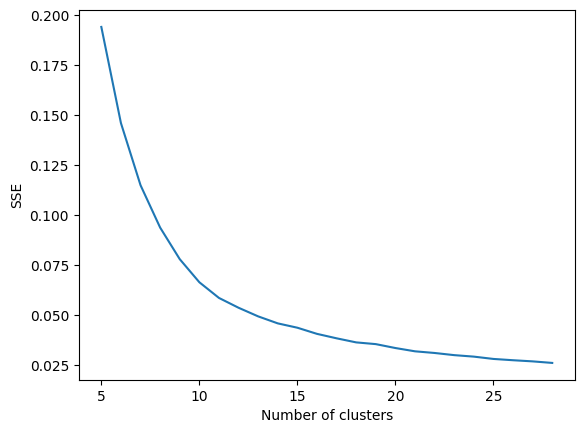

In [13]:
# Plot the SSE curve w.r.t. the scaler with the best performance
best_scaler = df_compression_based_res.iloc[0]['scaler']
best_n_segment = df_compression_based_res.iloc[0]['n_segments']
df_sse_curve = df_compression_based_res[df_compression_based_res['scaler'].apply(lambda x: best_scaler in x)]
df_sse_curve = df_sse_curve[df_sse_curve['n_segments'].apply(lambda x: x == best_n_segment)]
df_sse_curve.sort_values(by=['n_centr'], inplace=True)
sse_list = df_sse_curve.inertia.values
plt.plot(range(5, len(sse_list) + 5), sse_list)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.savefig(f'timeseries/compression_based_clustering/SSE_curve.png')
plt.show()

The best k is 8

In [17]:
# Re-run timeseries KMeans with the best configuration
k = 8
best_k = df_sse_curve[df_sse_curve['n_centr'] == k]
best_k = best_k.iloc[0]
data = timeseries_list.copy()
logged = to_log(data)
if 'TimeSeriesScalerMinMax' in best_k['scaler']:
    scaled = scale_ts(logged, TimeSeriesScalerMinMax(value_range=(1.0,2.0)))
else:
    scaled = scale_ts(logged, TimeSeriesScalerMeanVariance(mu=0., std=1.))

paa = PiecewiseAggregateApproximation(n_segments=best_k['n_segments'])
ts_paa = paa.fit_transform(scaled)

#Perform kmeans
kmeans = run_ts_kmeans(ts_paa, n_clust=best_k["n_centr"], metric=best_k["metrics"], out_path=False, dir='compression_based_clustering', scaler_name=best_k['scaler'])
labels = kmeans.labels_
print(f'Inertia: {kmeans.inertia_}')
get_metrics(scaled, kmeans.labels_)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_33592\3580474094.py:2: RuntimeWarning: divide by zero encountered in log
  data = np.log(data.astype('float64'))
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_33592\3580474094.py:2: RuntimeWarning: invalid value encountered in log
  data = np.log(data.astype('float64'))
c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


k=8
 1=1921  2=658  3=1198  4=512  5=1810  6=258  7=311  8=119 
Inertia: 0.058425118574927125
Silouhette score: 0.15126454706290193
Davies Bouldin score: 1.7088812089164305


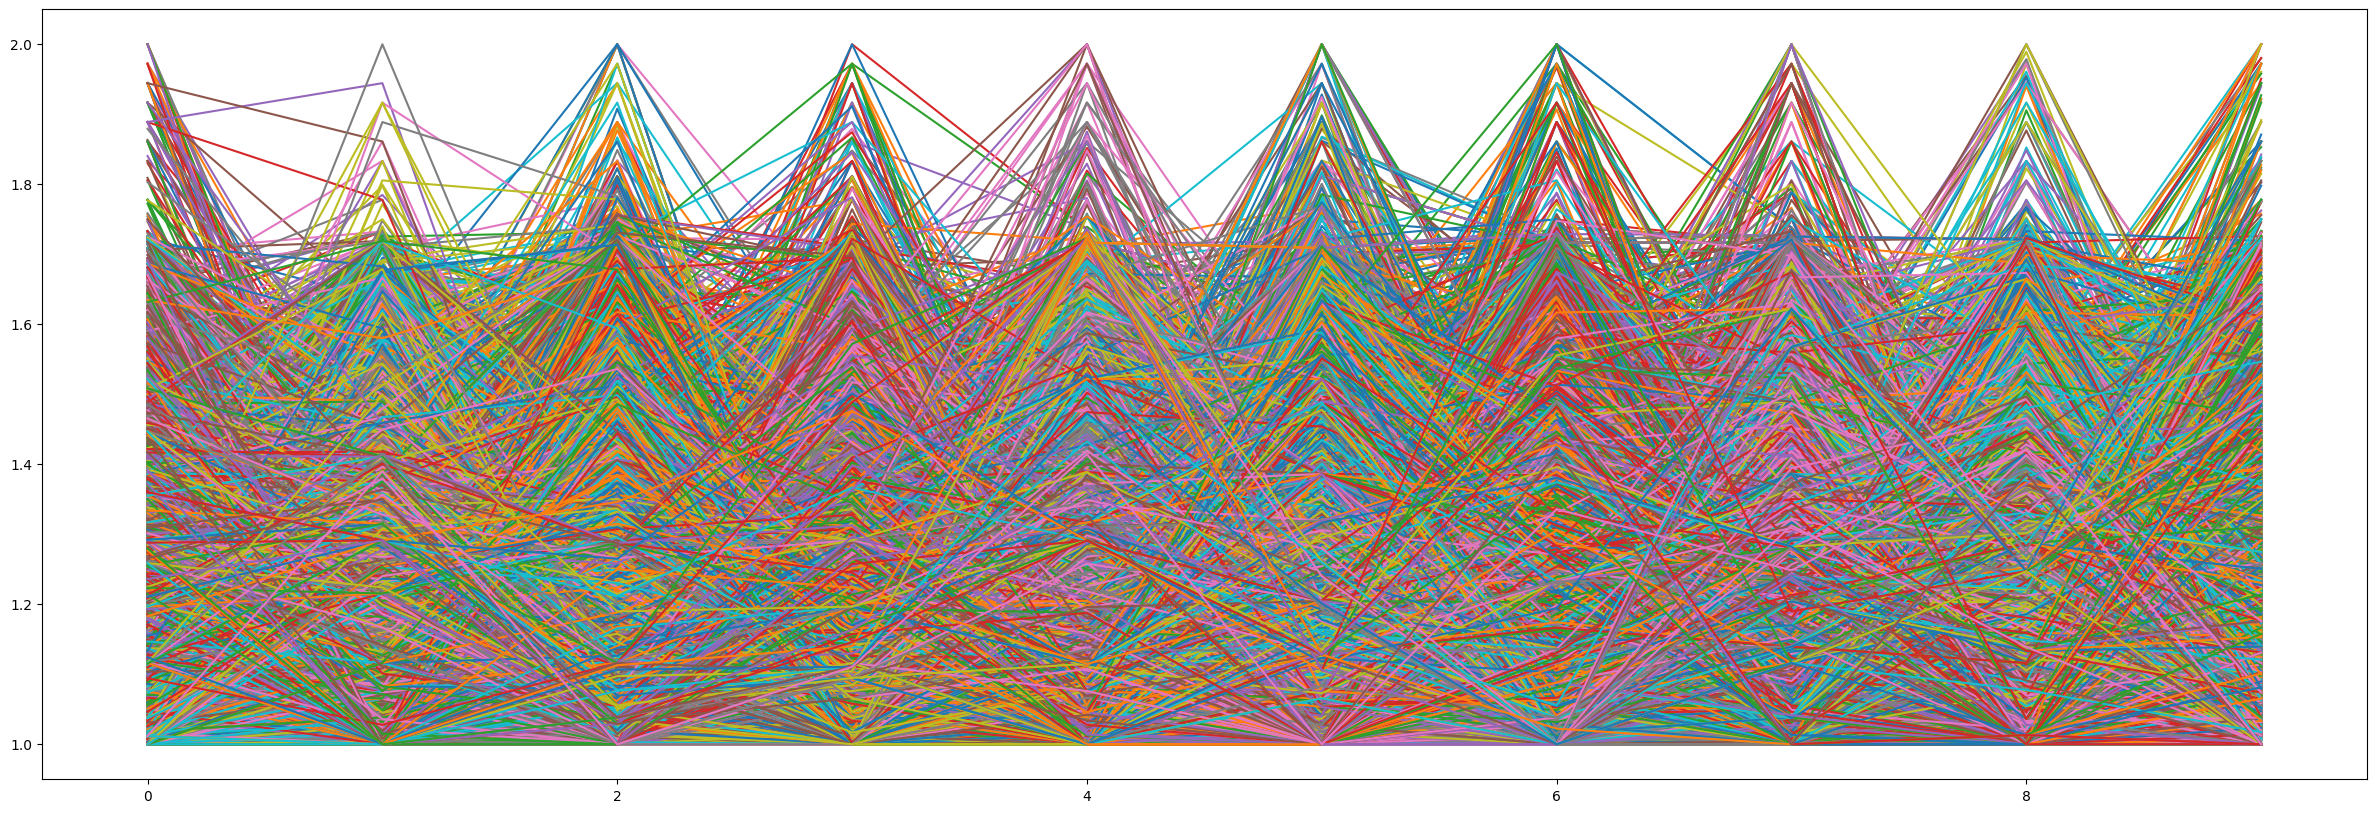

In [143]:
# Plot piecewise agggregated timeseries
plt.figure(figsize=(30,10))
plt.plot(ts_paa.reshape(ts_paa.shape[1], ts_paa.shape[0]))
plt.show()

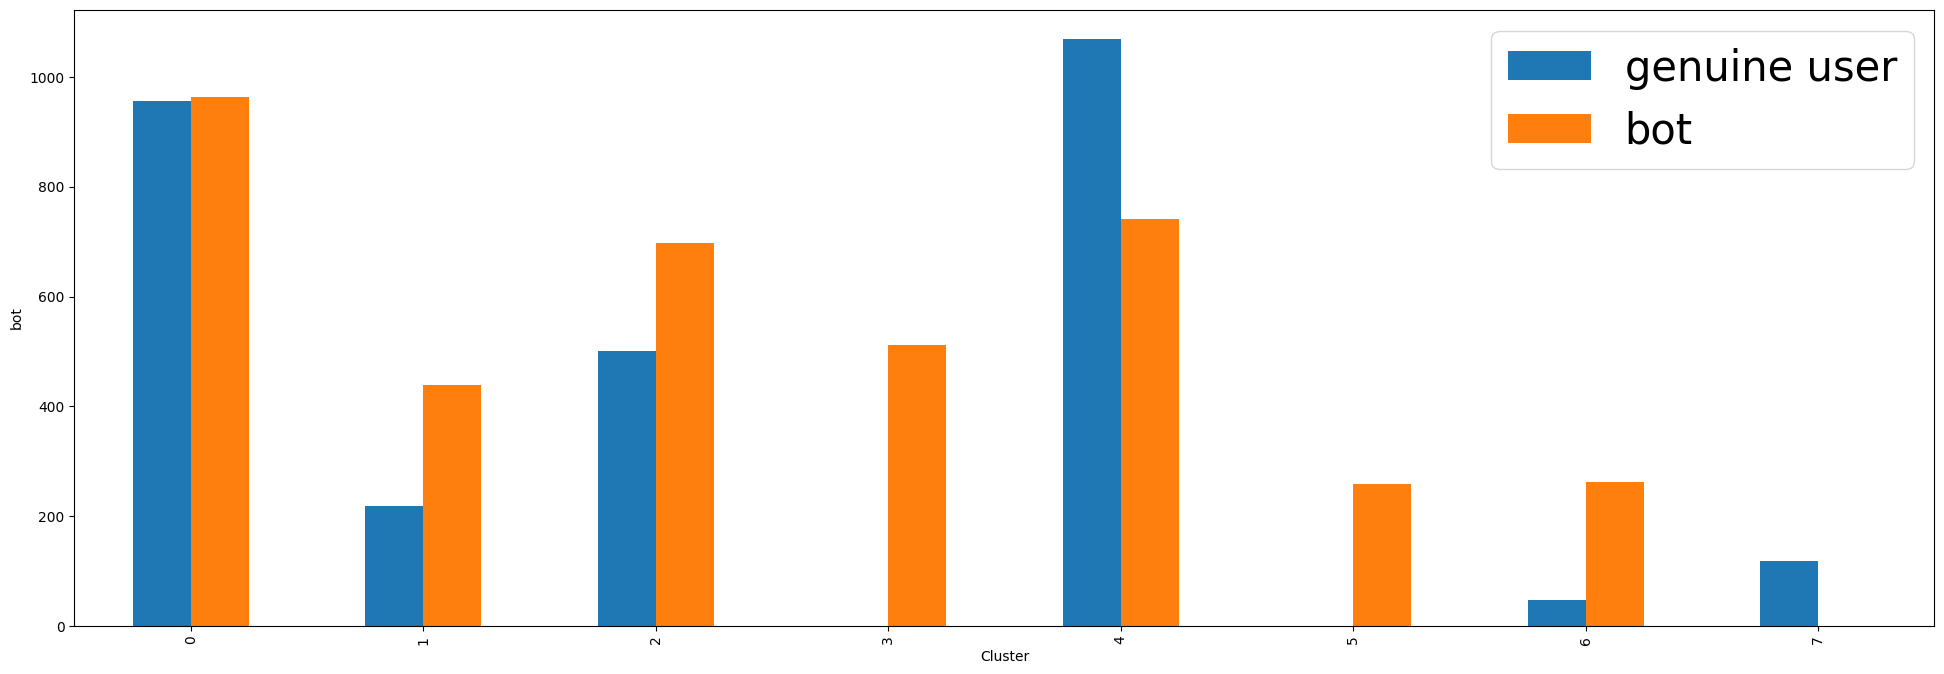

In [18]:
plot_crosstab(labels, df_ts_users.bot, ['genuine user', 'bot'], path=f'timeseries/compression_based_clustering')

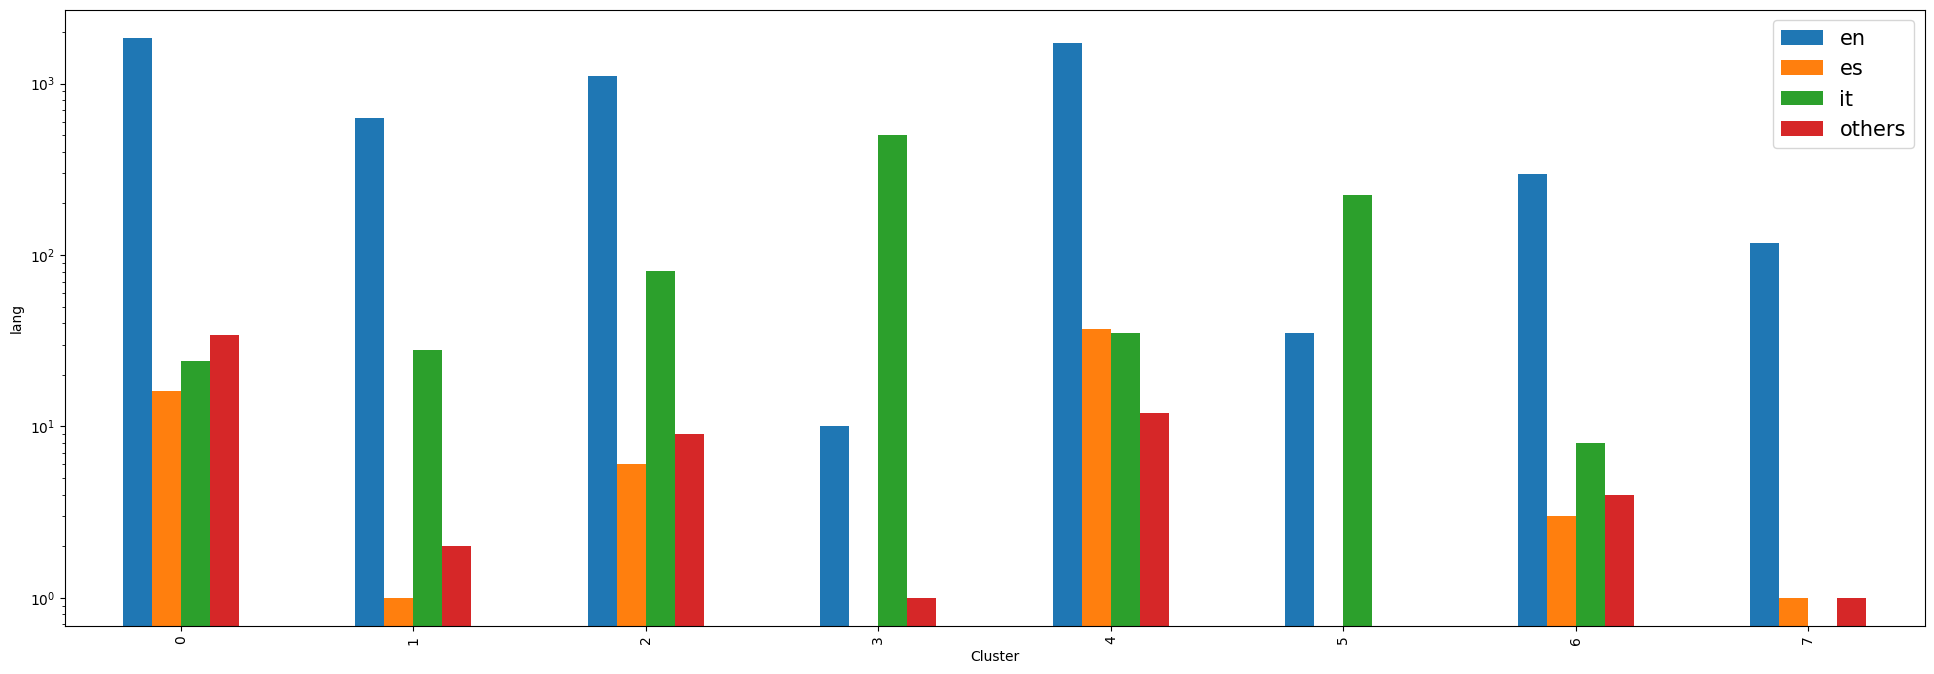

In [19]:
plot_lang_histogram(labels, df_ts_users.lang, out_path=True, path=f'timeseries/compression_based_clustering/lang_scatter.png')

# Shapelet

In [17]:
# Extract sizes to create shapelets
n_users, n_days = timeseries_list.shape
n_classes = 2
y = df_ts_users.bot.values
print(n_users)
print(n_days)
print(n_classes)
print(len(y))

6787
365
2
6787


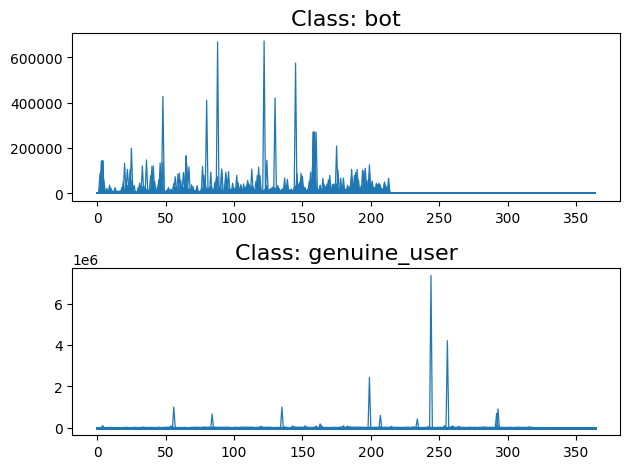

In [221]:
# Plot timeseries divided by classes
plt.figure()
for i, group in enumerate(['bot','genuine_user']):
    plt.subplot(2, 1, i + 1)
    for x in timeseries_list[y == i]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(group), fontsize=16)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [18]:
# Plot the pattern found by the ShapeletModel
def plot_shapelet(shapelet_dim, shapelet_model, predicted_locations, out_path=False, filename=''):
    ts_id = 0
    plt.figure(figsize=(30,10))
    n_shapelets = sum(shapelet_dim.values())
    plt.title(f'Example locations of shapelet matches ({n_shapelets} shapelets extracted)')

    plt.plot(timeseries_list[ts_id].ravel())
    for idx_shp, shp in enumerate(shapelet_model.shapelets_):
        t0 = predicted_locations[ts_id, idx_shp]
        plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

    if out_path:
        plt.savefig('./timeseries/'+filename)
    plt.show()

In [53]:
def classify_shapelet(tr_data, tr_labels, val_data, val_labels, l, r, weight_regularizer, optimizer, batch_size, max_iter=200, verbose=False, plot=False, out_path=False, scaler_name=''):
    
    # Extract sizes of shapelet
    shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_users,
                                                       ts_sz=n_days,
                                                       n_classes=n_classes,
                                                       l=l,
                                                       r=r)
    print('shapelet_sizes', shapelet_sizes)

    shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer=optimizer,
                        batch_size=batch_size,
                        weight_regularizer=weight_regularizer,
                        max_iter=max_iter,
                        verbose=verbose)

    # Train model and extract metrics
    shp_clf.fit(tr_data, tr_labels)
    
    predicted_tr_labels = shp_clf.predict(tr_data)
    predicted_val_labels = shp_clf.predict(val_data)

    # Compute accuracy, precision, recall and f1 scores for both train and validation
    tr_scores = [metrics.accuracy_score(tr_labels, predicted_tr_labels), 
                metrics.precision_score(tr_labels, predicted_tr_labels, average='weighted'),
                metrics.recall_score(tr_labels, predicted_tr_labels, average='weighted'),
                metrics.f1_score(tr_labels, predicted_tr_labels, average='weighted')]

    val_scores = [metrics.accuracy_score(val_labels, predicted_val_labels), 
                metrics.precision_score(val_labels, predicted_val_labels, average='weighted'),
                metrics.recall_score(val_labels, predicted_val_labels, average='weighted'),
                metrics.f1_score(val_labels, predicted_val_labels, average='weighted')]

    return tr_scores, val_scores

In [70]:
def test_shapelet(tr_data, tr_labels, ts_data, ts_labels, l, r, weight_regularizer, optimizer, batch_size, max_iter=200, verbose=False, plot=False, out_path=False, scaler_name=''):

    # Extract sizes of shapelet
    shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_users,
                                                       ts_sz=n_days,
                                                       n_classes=n_classes,
                                                       l=l, 
                                                       r=r)
    print('shapelet_sizes', shapelet_sizes)

    shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer=optimizer,
                        batch_size=batch_size,
                        weight_regularizer=weight_regularizer,
                        max_iter=max_iter,
                        verbose=verbose)
                        
    # Train model and print results
    shp_clf.fit(tr_data, tr_labels)

    predicted_tr_labels = shp_clf.predict(tr_data)
    
    predicted_ts_labels = shp_clf.predict(ts_data)
    predicted_ts_locations = shp_clf.locate(ts_data)

    # Compute accuracy, precision, recall and f1 scores for both train and validation
    tr_scores = [metrics.accuracy_score(tr_labels, predicted_tr_labels), 
                metrics.precision_score(tr_labels, predicted_tr_labels, average='weighted'),
                metrics.recall_score(tr_labels, predicted_tr_labels, average='weighted'),
                metrics.f1_score(tr_labels, predicted_tr_labels, average='weighted')]

    ts_scores = [metrics.accuracy_score(ts_labels, predicted_ts_labels), 
                metrics.precision_score(ts_labels, predicted_ts_labels, average='weighted'),
                metrics.recall_score(ts_labels, predicted_ts_labels, average='weighted'),
                metrics.f1_score(ts_labels, predicted_ts_labels, average='weighted')]

    print(f'Training scores:\n\tAccuracy:{tr_scores[0]}\n\tPrecision:{tr_scores[1]}\n\tRecall:{tr_scores[2]}\n\tF1 score:{tr_scores[3]}')
    print(f'Testing scores:\n\tAccuracy:{ts_scores[0]}\n\tPrecision:{ts_scores[1]}\n\tRecall:{ts_scores[2]}\n\tF1 score:{ts_scores[3]}')

    if plot:
        plot_shapelet(shapelet_sizes, shp_clf, predicted_ts_locations, out_path=out_path, filename=f'shapelet_{l}_{r}_{weight_regularizer}_{optimizer}_{scaler_name}.png')

In [22]:
data_to_shape = timeseries_list.copy()

In [24]:
# Split data in train, validation and test
from sklearn.model_selection import train_test_split
dev, ts, dev_labels, ts_labels = train_test_split(data_to_shape, y,
                                                          stratify=y, test_size=0.20)
tr, val, tr_labels, val_labels = train_test_split(dev, dev_labels,
                                                          stratify=dev_labels, test_size=0.10)

In [59]:
tr_data = tr.copy()
val_data = val.copy()
ts_data = ts.copy()

In [55]:
# Grid search for shapelet classification
params = {
    "scaler": [TimeSeriesScalerMeanVariance(mu=0., std=1.)],
    "l": [0.5, 0.7, 0.9],
    "r": [1],
    "batch_size": [64, 128, 256, 512],
    "weight_reg": [0.0, 1e-3, 0.01, 0.03, 0.05, 0.07, 1e-1],
    "max_iter": [250],
    "opt": ["Adam"]
}

keys, values = zip(*params.items())
combo_list = list(it.product(*(values)))

# Log timeseries to improve performances
tr_logged = to_log(tr_data)
val_logged = to_log(val_data)
res = []

for i in tqdm(range(len(combo_list))):
    
    res_dict = {
        "scaler": combo_list[i][0],
        "l" : combo_list[i][1],
        "r" : combo_list[i][2],
        "batch_size": combo_list[i][3],
        "weight_reg" : combo_list[i][4],
        "max_iter": combo_list[i][5],
        "opt": combo_list[i][6]
    }

    print(res_dict)

    # Scaling timeseries
    tr_scaled = scale_ts(tr_logged, res_dict["scaler"])
    val_scaled = scale_ts(val_logged, res_dict["scaler"])

    #Perform classification
    tr_scores, val_scores = classify_shapelet(tr_scaled, tr_labels, val_scaled, val_labels, res_dict["l"], res_dict["r"], res_dict["weight_reg"], res_dict["opt"], res_dict["batch_size"], max_iter=200, verbose=False)
    
    # Extract scores
    res_dict["tr_accuracy"] = tr_scores[0]
    res_dict["tr_precision"] = tr_scores[1]
    res_dict["tr_recall"] = tr_scores[2]
    res_dict["tr_f1"] = tr_scores[3]

    res_dict["val_accuracy"] = val_scores[0]
    res_dict["val_precision"] = val_scores[1]
    res_dict["val_recall"] = val_scores[2]
    res_dict["val_f1"] = val_scores[3]
    
    res.append(res_dict)

df_res = pd.DataFrame(res)
df_res.to_csv(DATA_PATH+"shapelet_grid.csv", sep='#')
    

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_960\886371959.py:2: RuntimeWarning: divide by zero encountered in log
  data = np.log(data.astype('float64'))
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_960\886371959.py:2: RuntimeWarning: invalid value encountered in log
  data = np.log(data.astype('float64'))
  0%|          | 0/84 [00:00<?, ?it/s]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 64, 'weight_reg': 0.0, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
  1%|          | 1/84 [03:20<4:38:00, 200.97s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 64, 'weight_reg': 0.001, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
  2%|▏         | 2/84 [06:58<4:47:36, 210.44s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 64, 'weight_reg': 0.01, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
  4%|▎         | 3/84 [10:42<4:52:31, 216.69s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 64, 'weight_reg': 0.03, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
  5%|▍         | 4/84 [13:58<4:38:09, 208.62s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 64, 'weight_reg': 0.05, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
  6%|▌         | 5/84 [17:23<4:33:01, 207.37s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 64, 'weight_reg': 0.07, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
  7%|▋         | 6/84 [21:10<4:38:07, 213.94s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 64, 'weight_reg': 0.1, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
  8%|▊         | 7/84 [24:53<4:38:31, 217.03s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 128, 'weight_reg': 0.0, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 10%|▉         | 8/84 [28:09<4:26:21, 210.28s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 128, 'weight_reg': 0.001, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 11%|█         | 9/84 [31:24<4:17:03, 205.65s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 128, 'weight_reg': 0.01, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 12%|█▏        | 10/84 [34:40<4:09:56, 202.66s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 128, 'weight_reg': 0.03, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 13%|█▎        | 11/84 [37:55<4:03:26, 200.09s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 128, 'weight_reg': 0.05, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 14%|█▍        | 12/84 [41:14<3:59:56, 199.96s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 128, 'weight_reg': 0.07, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 15%|█▌        | 13/84 [44:32<3:55:51, 199.31s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 128, 'weight_reg': 0.1, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 17%|█▋        | 14/84 [47:47<3:50:55, 197.94s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 256, 'weight_reg': 0.0, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 18%|█▊        | 15/84 [50:45<3:40:39, 191.88s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 256, 'weight_reg': 0.001, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 19%|█▉        | 16/84 [54:15<3:43:33, 197.26s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 256, 'weight_reg': 0.01, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 20%|██        | 17/84 [57:24<3:37:40, 194.93s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 256, 'weight_reg': 0.03, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 21%|██▏       | 18/84 [1:00:35<3:33:11, 193.81s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 256, 'weight_reg': 0.05, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 23%|██▎       | 19/84 [1:03:37<3:26:09, 190.30s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 256, 'weight_reg': 0.07, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 24%|██▍       | 20/84 [1:06:22<3:14:51, 182.67s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 256, 'weight_reg': 0.1, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 25%|██▌       | 21/84 [1:09:15<3:08:35, 179.61s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 512, 'weight_reg': 0.0, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 26%|██▌       | 22/84 [1:11:55<2:59:29, 173.69s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 512, 'weight_reg': 0.001, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 27%|██▋       | 23/84 [1:14:24<2:49:06, 166.34s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 512, 'weight_reg': 0.01, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 29%|██▊       | 24/84 [1:17:00<2:43:25, 163.42s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 512, 'weight_reg': 0.03, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 30%|██▉       | 25/84 [1:19:23<2:34:32, 157.16s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 512, 'weight_reg': 0.05, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 31%|███       | 26/84 [1:21:37<2:25:14, 150.26s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 512, 'weight_reg': 0.07, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 32%|███▏      | 27/84 [1:24:02<2:21:19, 148.76s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.5, 'r': 1, 'batch_size': 512, 'weight_reg': 0.1, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {182: 6}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 33%|███▎      | 28/84 [1:26:22<2:16:14, 145.97s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 64, 'weight_reg': 0.0, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 35%|███▍      | 29/84 [1:29:23<2:23:20, 156.38s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 64, 'weight_reg': 0.001, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 36%|███▌      | 30/84 [1:32:06<2:22:43, 158.58s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 64, 'weight_reg': 0.01, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 37%|███▋      | 31/84 [1:35:00<2:24:02, 163.07s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 64, 'weight_reg': 0.03, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 38%|███▊      | 32/84 [1:37:55<2:24:28, 166.70s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 64, 'weight_reg': 0.05, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 39%|███▉      | 33/84 [1:42:01<2:42:00, 190.60s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 64, 'weight_reg': 0.07, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 40%|████      | 34/84 [1:45:44<2:46:56, 200.34s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 64, 'weight_reg': 0.1, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 42%|████▏     | 35/84 [1:49:03<2:43:05, 199.71s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 128, 'weight_reg': 0.0, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 43%|████▎     | 36/84 [1:51:51<2:32:11, 190.25s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 128, 'weight_reg': 0.001, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 44%|████▍     | 37/84 [1:54:26<2:20:52, 179.83s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 128, 'weight_reg': 0.01, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 45%|████▌     | 38/84 [1:57:14<2:15:08, 176.26s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 128, 'weight_reg': 0.03, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 46%|████▋     | 39/84 [2:00:00<2:09:48, 173.09s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 128, 'weight_reg': 0.05, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 48%|████▊     | 40/84 [2:02:17<1:59:00, 162.29s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 128, 'weight_reg': 0.07, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 49%|████▉     | 41/84 [2:04:29<1:49:43, 153.12s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 128, 'weight_reg': 0.1, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 50%|█████     | 42/84 [2:06:45<1:43:44, 148.21s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 256, 'weight_reg': 0.0, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 51%|█████     | 43/84 [2:08:47<1:35:53, 140.32s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 256, 'weight_reg': 0.001, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 52%|█████▏    | 44/84 [2:10:41<1:28:12, 132.31s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 256, 'weight_reg': 0.01, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 54%|█████▎    | 45/84 [2:12:45<1:24:26, 129.92s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 256, 'weight_reg': 0.03, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 55%|█████▍    | 46/84 [2:14:42<1:19:43, 125.88s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 256, 'weight_reg': 0.05, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 56%|█████▌    | 47/84 [2:16:42<1:16:34, 124.17s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 256, 'weight_reg': 0.07, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 57%|█████▋    | 48/84 [2:18:47<1:14:42, 124.50s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 256, 'weight_reg': 0.1, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 58%|█████▊    | 49/84 [2:20:54<1:12:59, 125.13s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 512, 'weight_reg': 0.0, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 60%|█████▉    | 50/84 [2:22:56<1:10:23, 124.22s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 512, 'weight_reg': 0.001, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 61%|██████    | 51/84 [2:28:03<1:38:26, 179.00s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 512, 'weight_reg': 0.01, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 62%|██████▏   | 52/84 [2:32:53<1:53:19, 212.48s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 512, 'weight_reg': 0.03, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 63%|██████▎   | 53/84 [2:37:06<1:56:03, 224.64s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 512, 'weight_reg': 0.05, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 64%|██████▍   | 54/84 [2:40:57<1:53:13, 226.44s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 512, 'weight_reg': 0.07, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 65%|██████▌   | 55/84 [2:44:25<1:46:42, 220.77s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.7, 'r': 1, 'batch_size': 512, 'weight_reg': 0.1, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {255: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 67%|██████▋   | 56/84 [2:47:46<1:40:16, 214.89s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 64, 'weight_reg': 0.0, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 68%|██████▊   | 57/84 [2:50:17<1:28:03, 195.69s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 64, 'weight_reg': 0.001, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 69%|██████▉   | 58/84 [2:52:27<1:16:21, 176.20s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 64, 'weight_reg': 0.01, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 70%|███████   | 59/84 [2:54:07<1:03:48, 153.15s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 64, 'weight_reg': 0.03, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 71%|███████▏  | 60/84 [2:55:47<54:51, 137.15s/it]  

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 64, 'weight_reg': 0.05, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 73%|███████▎  | 61/84 [2:57:24<47:59, 125.17s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 64, 'weight_reg': 0.07, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 74%|███████▍  | 62/84 [2:59:03<43:01, 117.32s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 64, 'weight_reg': 0.1, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 75%|███████▌  | 63/84 [3:00:42<39:11, 111.97s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 128, 'weight_reg': 0.0, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 76%|███████▌  | 64/84 [3:02:07<34:37, 103.87s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 128, 'weight_reg': 0.001, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 77%|███████▋  | 65/84 [3:03:24<30:17, 95.65s/it] 

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 128, 'weight_reg': 0.01, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 79%|███████▊  | 66/84 [3:04:45<27:22, 91.26s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 128, 'weight_reg': 0.03, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 80%|███████▉  | 67/84 [3:06:09<25:16, 89.19s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 128, 'weight_reg': 0.05, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 81%|████████  | 68/84 [3:07:26<22:49, 85.58s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 128, 'weight_reg': 0.07, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 82%|████████▏ | 69/84 [3:08:51<21:22, 85.47s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 128, 'weight_reg': 0.1, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 83%|████████▎ | 70/84 [3:14:09<36:12, 155.16s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 256, 'weight_reg': 0.0, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 85%|████████▍ | 71/84 [3:18:44<41:25, 191.19s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 256, 'weight_reg': 0.001, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 86%|████████▌ | 72/84 [3:22:40<40:53, 204.49s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 256, 'weight_reg': 0.01, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 87%|████████▋ | 73/84 [3:26:13<37:59, 207.20s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 256, 'weight_reg': 0.03, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 88%|████████▊ | 74/84 [3:29:22<33:37, 201.71s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 256, 'weight_reg': 0.05, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 89%|████████▉ | 75/84 [3:32:19<29:06, 194.07s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 256, 'weight_reg': 0.07, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 90%|█████████ | 76/84 [3:34:31<23:24, 175.55s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 256, 'weight_reg': 0.1, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 92%|█████████▏| 77/84 [3:36:42<18:55, 162.24s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 512, 'weight_reg': 0.0, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 93%|█████████▎| 78/84 [3:38:29<14:32, 145.49s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 512, 'weight_reg': 0.001, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 94%|█████████▍| 79/84 [3:39:45<10:23, 124.79s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 512, 'weight_reg': 0.01, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 95%|█████████▌| 80/84 [3:40:52<07:10, 107.54s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 512, 'weight_reg': 0.03, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 96%|█████████▋| 81/84 [3:41:58<04:45, 95.04s/it] 

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 512, 'weight_reg': 0.05, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 98%|█████████▊| 82/84 [3:43:15<02:59, 89.68s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 512, 'weight_reg': 0.07, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
 99%|█████████▉| 83/84 [3:44:30<01:25, 85.25s/it]

{'scaler': TimeSeriesScalerMeanVariance(), 'l': 0.9, 'r': 1, 'batch_size': 512, 'weight_reg': 0.1, 'max_iter': 250, 'opt': 'Adam'}
shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
100%|██████████| 84/84 [3:45:47<00:00, 161.28s/it]


In [56]:
df_results = pd.read_csv(DATA_PATH+'shapelet_grid.csv', sep='#')

In [60]:
df_results.sort_values(by=['val_accuracy'], ascending=False, inplace=True)
best_combo = df_results.iloc[0]
best_combo

Unnamed: 0                                   56
scaler           TimeSeriesScalerMeanVariance()
l                                           0.9
r                                             1
batch_size                                   64
weight_reg                                  0.0
max_iter                                    250
opt                                        Adam
tr_accuracy                            0.831355
tr_precision                           0.847232
tr_recall                              0.831355
tr_f1                                  0.825606
val_accuracy                           0.856354
val_precision                          0.863028
val_recall                             0.856354
val_f1                                 0.853624
Name: 56, dtype: object

In [62]:
tr_logged = to_log(tr_data)
ts_logged = to_log(ts_data)
tr_scaled = scale_ts(tr_logged, eval(best_combo["scaler"]))
ts_scaled = scale_ts(ts_logged, eval(best_combo["scaler"]))

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_960\886371959.py:2: RuntimeWarning: divide by zero encountered in log
  data = np.log(data.astype('float64'))
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_960\886371959.py:2: RuntimeWarning: invalid value encountered in log
  data = np.log(data.astype('float64'))


shapelet_sizes {328: 5}


c:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Training scores:
	Accuracy:0.8276708964388048
	Precision:0.842594371632125
	Recall:0.8276708964388048
	F1 score:0.8219177769783704
Testing scores:
	Accuracy:0.8232695139911634
	Precision:0.833829160639706
	Recall:0.8232695139911634
	F1 score:0.8183304012512228


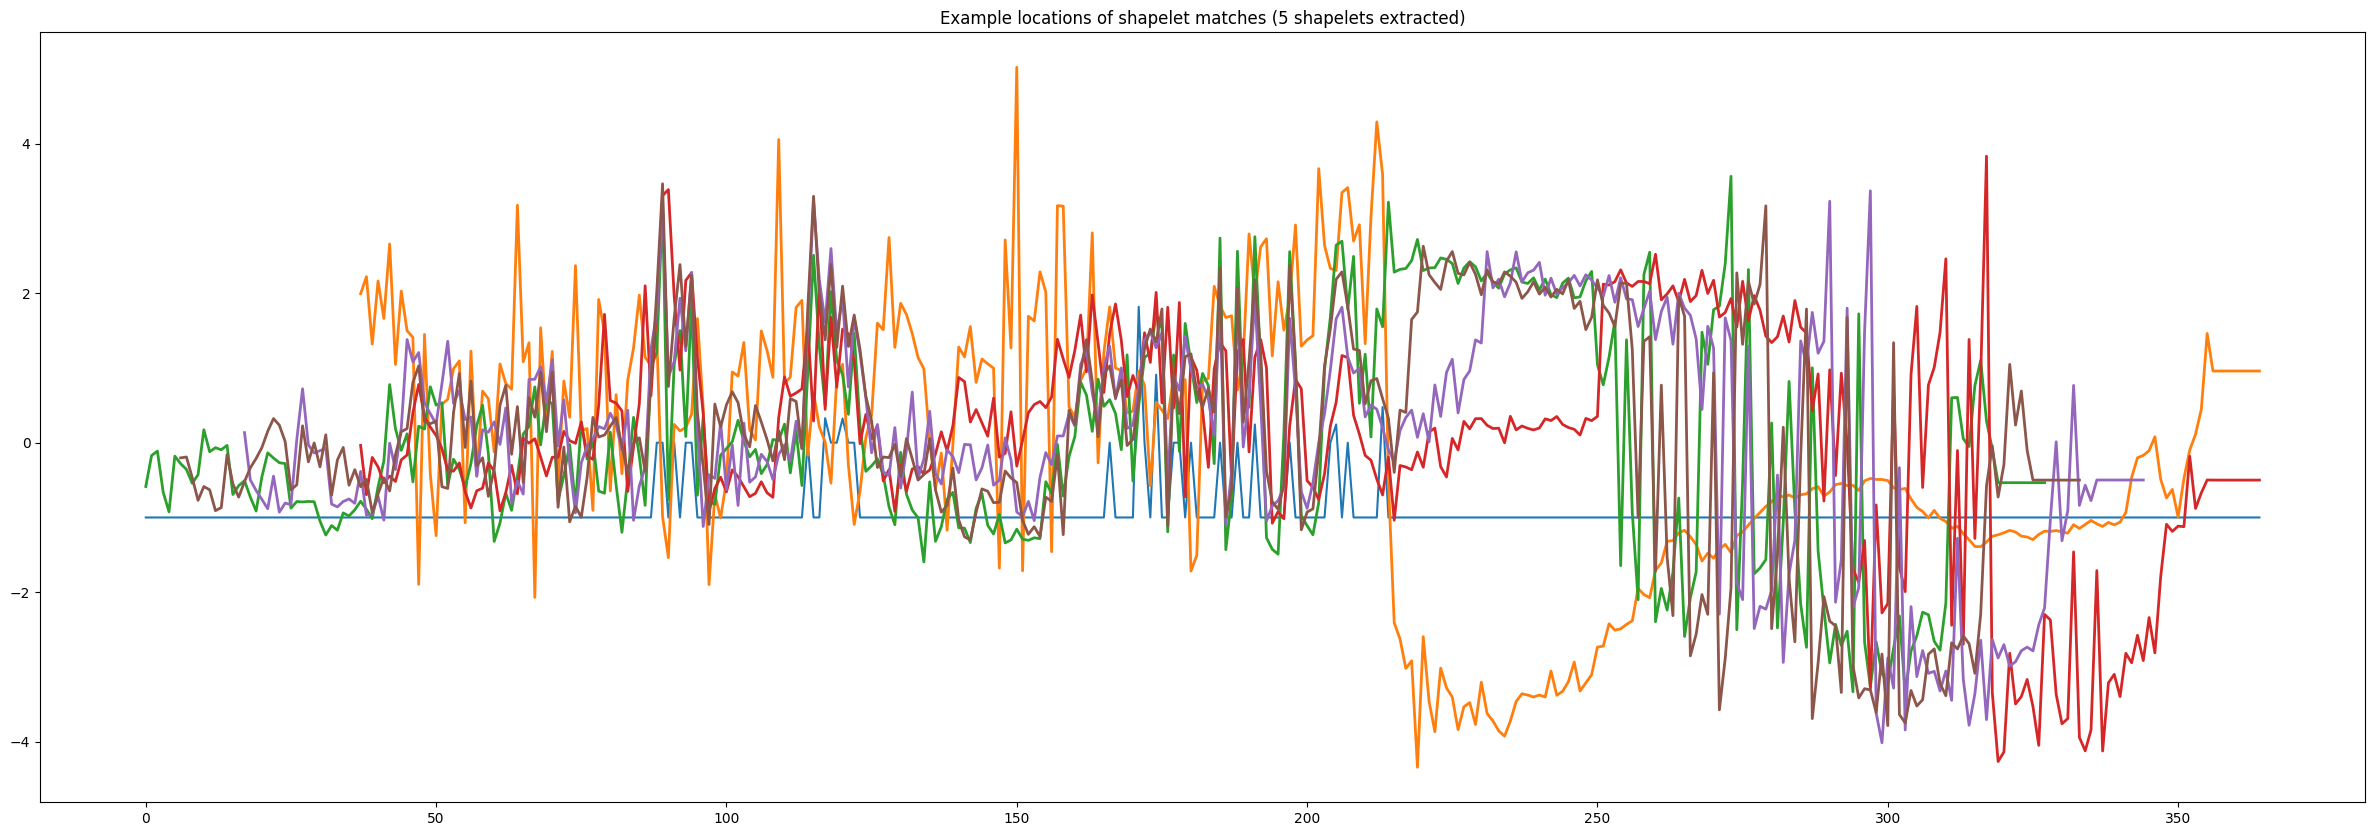

In [71]:
test_shapelet(tr_scaled, tr_labels, ts_scaled, ts_labels, best_combo['l'], best_combo['r'], best_combo['weight_reg'], best_combo['opt'], best_combo['batch_size'], max_iter=best_combo['max_iter'], plot=True, out_path=True, scaler_name='MeanVariance')